# Cluster Analysis of M66

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) # uncomment to see all the rows in a dataframe

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

from astropy.io import fits
from astropy.coordinates import FK5, SkyCoord
import astropy.units as u

from XRBID.DataFrameMod import (Find, FindUnique)
from XRBID.CMDs import FitSED
from XRBID.WriteScript import WriteReg
from XRBID.Sources import Crossref, GetDaoPhots

import os, sys
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
from helpers.analysis import remove_unnamed, find_parent_cluster
from helpers.analysis import (calculate_distance, calculate_velocity)

import seaborn as sns

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"


# Notes
- This analysis excludes the use of F336W filter of HST WFC3 as the measruements were terribly poor.

# Prepare full dataset

In [2]:
M66_notes = remove_unnamed(pd.read_csv(M66_dir+'M66_XRB_notes.csv'))
M66_daoclean = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_hst_jwst_xrbs_photometry.csv'))
M66_daoclean = M66_daoclean.drop(columns='Class')

In [3]:
# Add the XRB Class to the df
M66_xrbs = M66_notes[['CSC ID', 'ID', 'Class', 'JWST ID', 'HST ID']].merge(M66_daoclean, on=['CSC ID', 'JWST ID', 'HST ID'], how='left')
M66_xrbs = M66_xrbs.drop(columns='Auxiliary ID')

# Create a new ID for easy best fit identification
M66_xrbs['Auxiliary ID'] = M66_xrbs['CSC ID'] + '-' + M66_xrbs['JWST ID'].astype(str) + '-' + M66_xrbs['HST ID'].astype(str)

# Only use the XRBs, not clusters
M66_xrbs = M66_xrbs.query('`Class` == ["HMXB", "LMXB", "IMXB"]').reset_index(drop=True)
M66_xrbs

,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,Auxiliary ID
0,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,NaN,NaN,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,2CXO J112014.9+125933-3.0-2.0
1,2CXO J112015.3+125932,CXO005,LMXB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112015.3+125932-nan-nan
2,2CXO J112015.0+125936,CXO006,HMXB,2.0,1.0,170.062808,12.993437,200852.0,46417.0,42593.0,48557.0,3048.131145,6003.004427,3700.317585,5908.701948,19792.0,NaN,NaN,36916.0,NaN,170.062784,12.993454,NaN,184.978557,-11.584072,-1.756274,-12.044657,-1.388903,-12.183175,-1.228733,NaN,NaN,NaN,NaN,NaN,1.142291,NaN,1.536468,NaN,NaN,2CXO J112015.0+125936-2.0-1.0
3,2CXO J112015.0+125921,CXO007,HMXB,7.0,1.0,170.062475,12.989191,169350.0,39698.0,36199.0,41583.0,3086.128147,5505.907098,3727.624318,5519.646556,16435.0,NaN,NaN,NaN,NaN,170.062475,12.989172,NaN,13.846357,-10.932239,-2.894194,-11.094335,-2.970991,-11.154931,-2.804088,NaN,NaN,NaN,NaN,NaN,NaN,-6.695964,-2.693151,NaN,NaN,2CXO J112015.0+125921-7.0-1.0
4,2CXO J112015.2+125921,CXO008,HMXB,7.0,3.0,170.063489,12.989460,171191.0,NaN,NaN,NaN,2970.358329,5537.339696,3640.754910,5546.285666,16686.0,NaN,NaN,NaN,NaN,170.063456,12.989465,-10.401179,-2.258856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.551823,-3.289136,NaN,NaN,2CXO J112015.2+125921-7.0-3.0
5,2CXO J112014.7+125937,CXO009,HMXB,7.0,1.0,170.061275,12.993558,201863.0,NaN,NaN,NaN,3222.967034,6017.205864,3834.343555,5918.287693,19852.0,NaN,NaN,37022.0,NaN,170.061270,12.993559,-9.975986,-3.230107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.744178,-7.880962,-6.233019,-4.222578,NaN,NaN,2CXO J112014.7+125937-7.0-1.0
6,2CXO J112015.0+125938,CXO010,HMXB,6.0,1.0,170.062865,12.993964,204900.0,NaN,NaN,NaN,3041.554415,6064.707748,3694.780748,5952.563551,20110.0,134991.0,NaN,NaN,NaN,170.062846,12.993936,-9.586088,-4.277069,NaN,NaN,NaN,NaN,NaN,NaN,-5.450522,-0.102546,NaN,NaN,NaN,NaN,-5.292991,-6.290347,NaN,NaN,2CXO J112015.0+125938-6.0-1.0
7,2CXO J112014.2+125927,CXO011,LMXB,3.0,NaN,170.059328,12.990910,182257.0,42409.0,38745.0,44337.0,3445.041678,5707.156183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.365068,-0.780651,-9.906455,-2.639223,-10.491327,-1.836659,-10.608536,-1.645945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.2+125927-3.0-nan
8,2CXO J112014.1+125923,CXO012,LMXB,3.0,NaN,170.058784,12.989716,173327.0,40534.0,36971.0,42428.0,3507.120121,5567.361186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.280691,-1.462720,-8.043054,-10.280138,-8.293276,-9.718285,-7.756413,-15.829940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.1+125923-3.0-nan
9,2CXO J112014.3+125918,CXO013,LMXB,4.0,NaN,170.059730,12.988352,163096.0,38416.0,34983.0,NaN,3399.258592,5407.640929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.930437,-2.478914,-10.142517,-1.846408,-10.349826,-1.832567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.3+125918-4.0-nan


In [4]:
# Remove F336W filter to crosscheck results
M66_xrbs = M66_xrbs.drop(columns=['F336W', 'F336W Err'])

## SED fitting of best-stars

Finding best-fit model(s)...
DONE


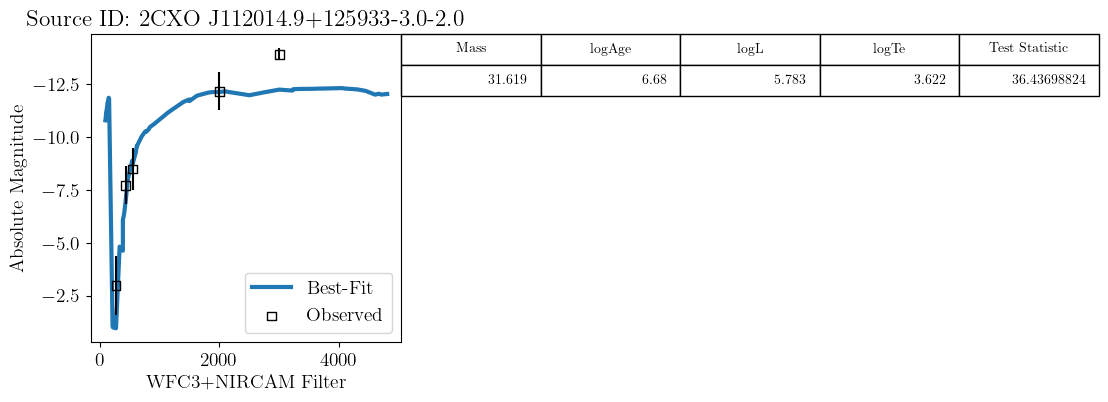

No best-fit model available for Source ID 2CXO J112015.3+125932-nan-nan.


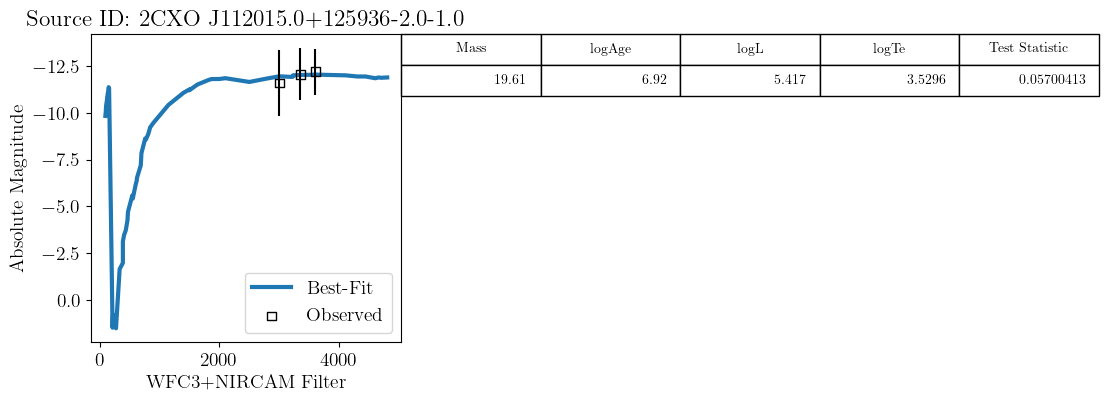

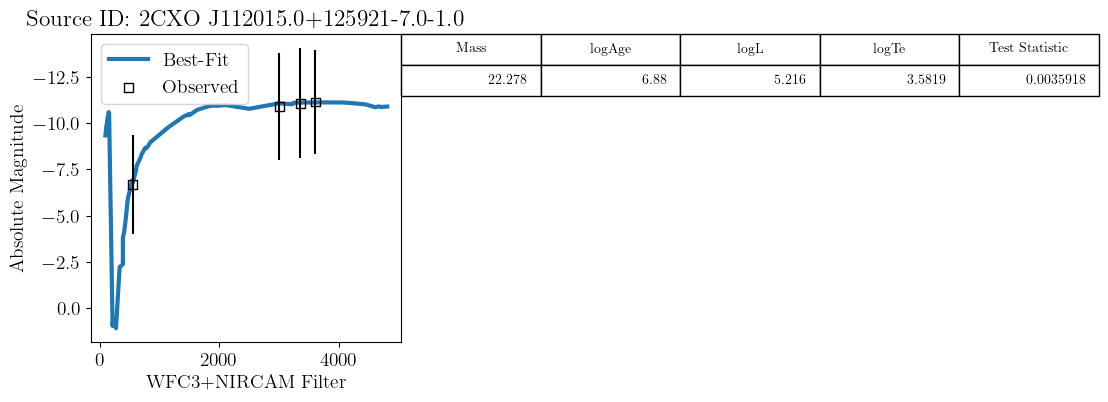

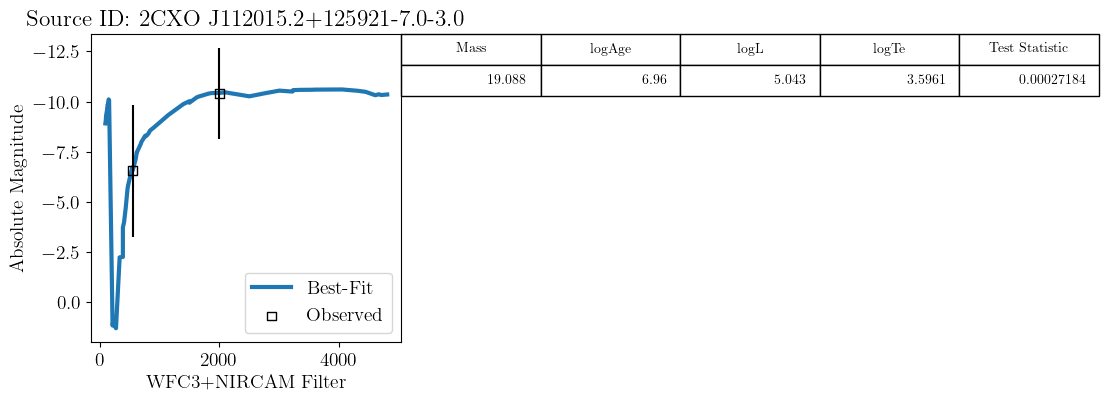

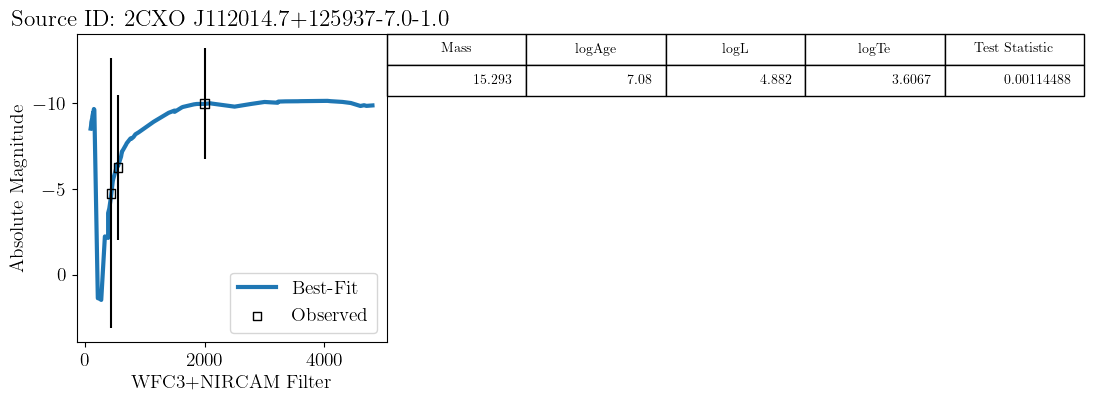

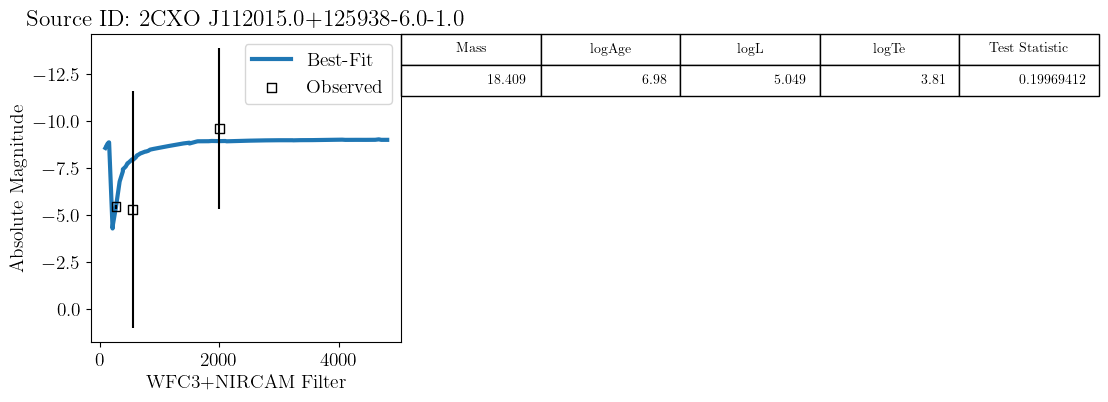

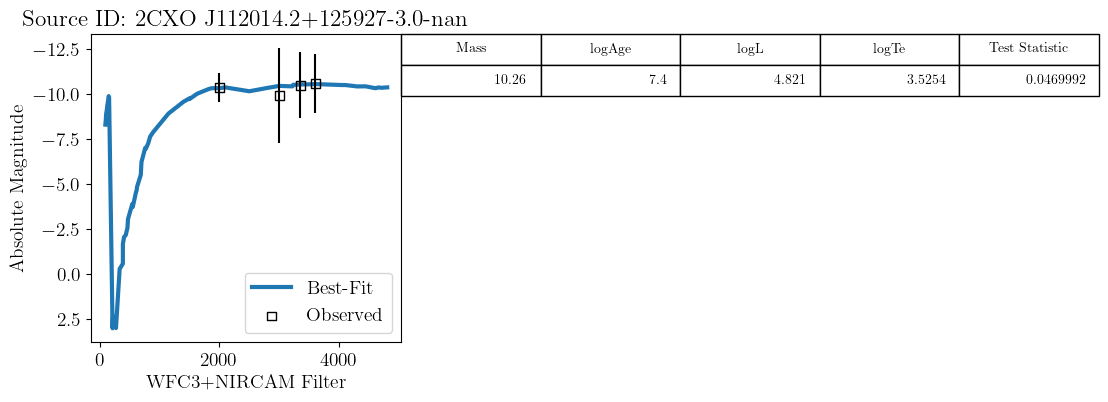

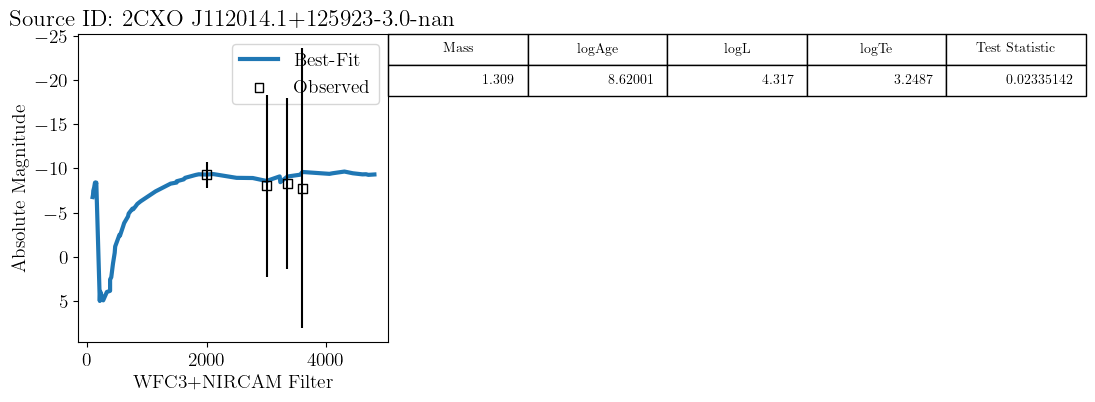

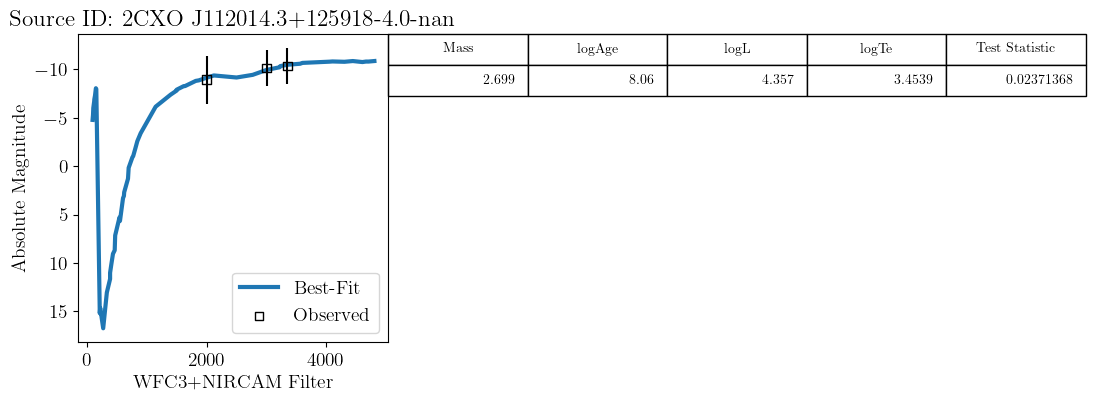

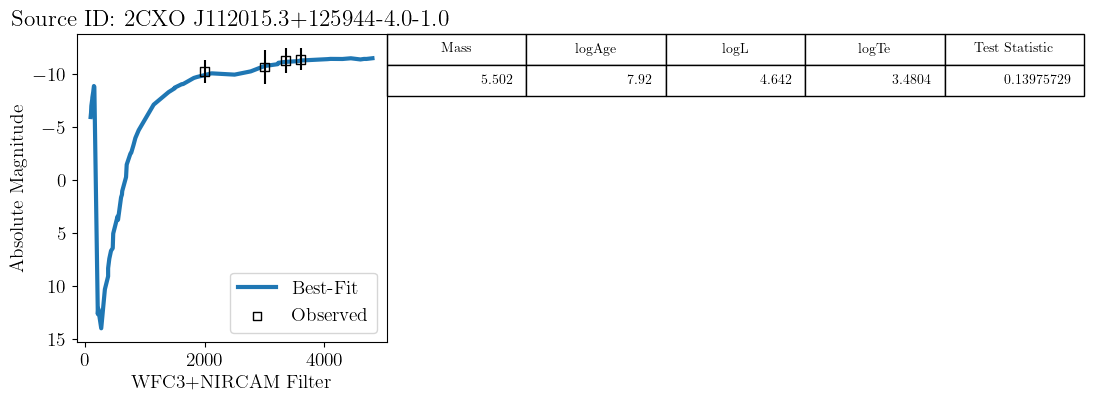

No best-fit model available for Source ID 2CXO J112014.5+125946-nan-nan.


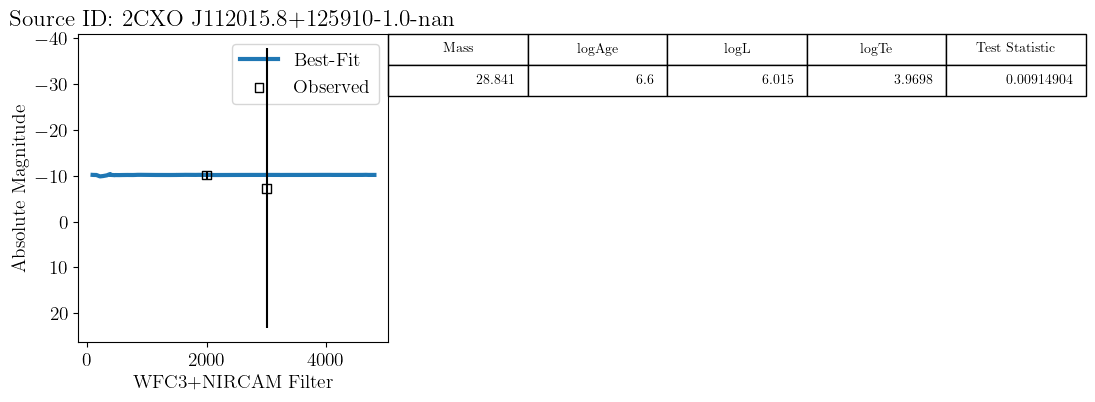

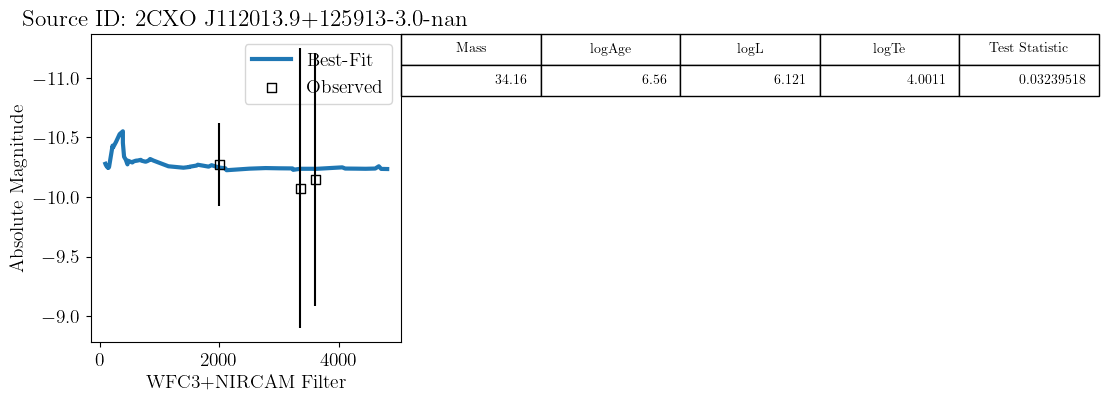

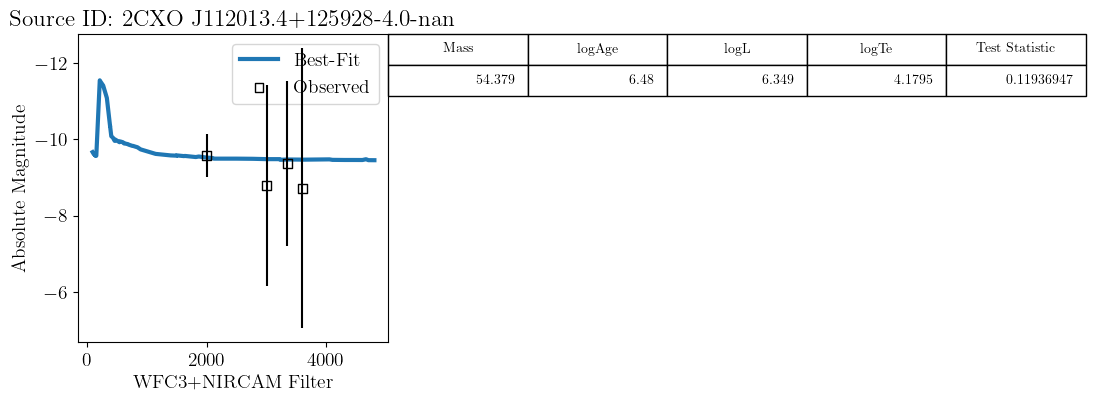

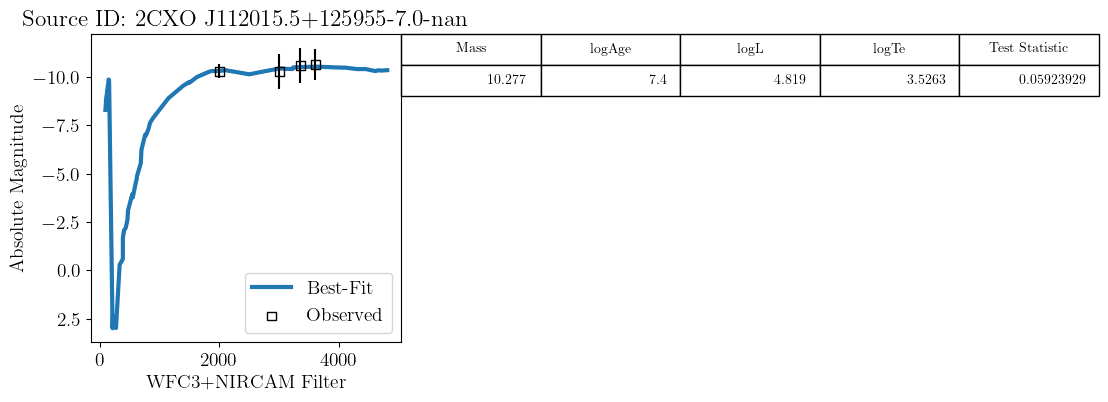

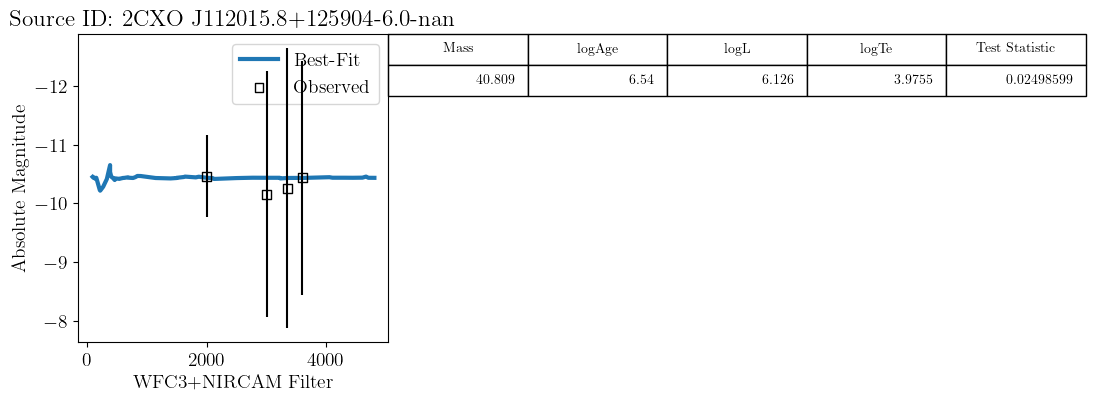

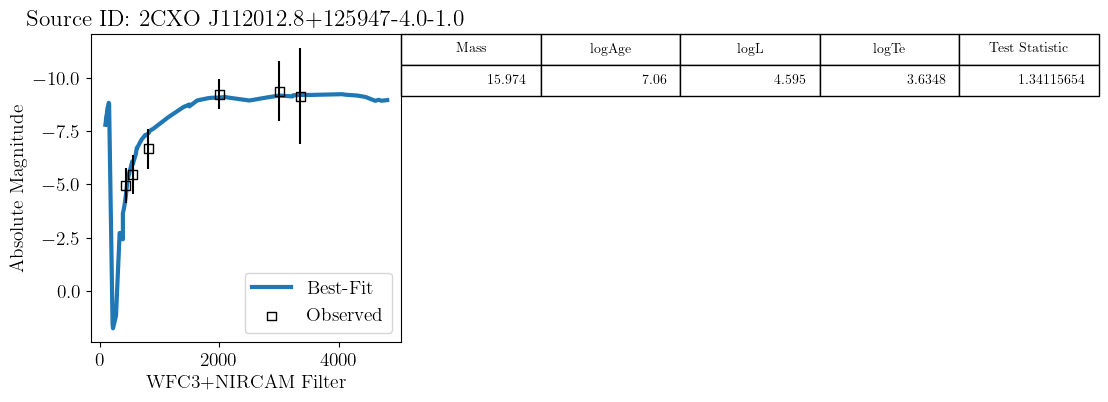

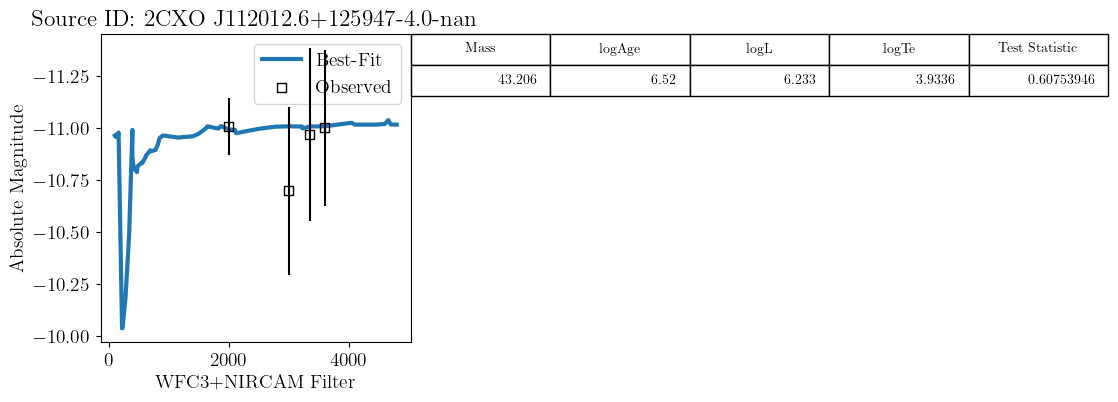

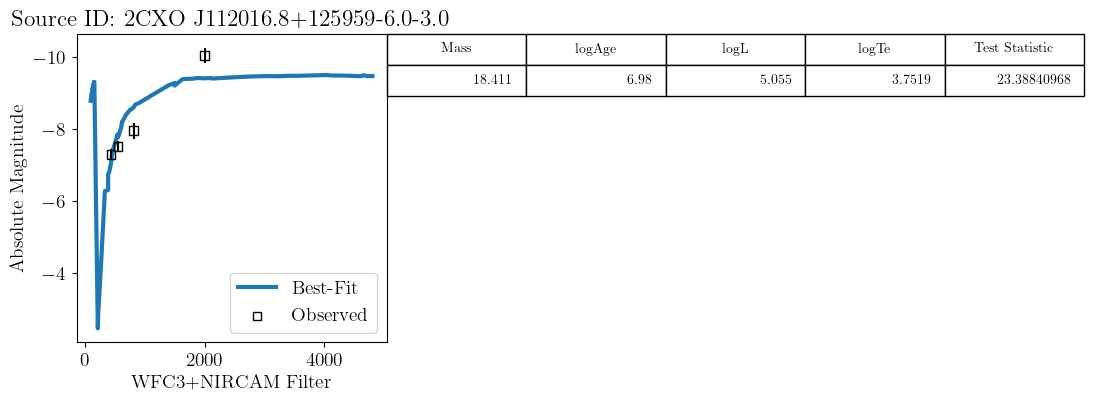

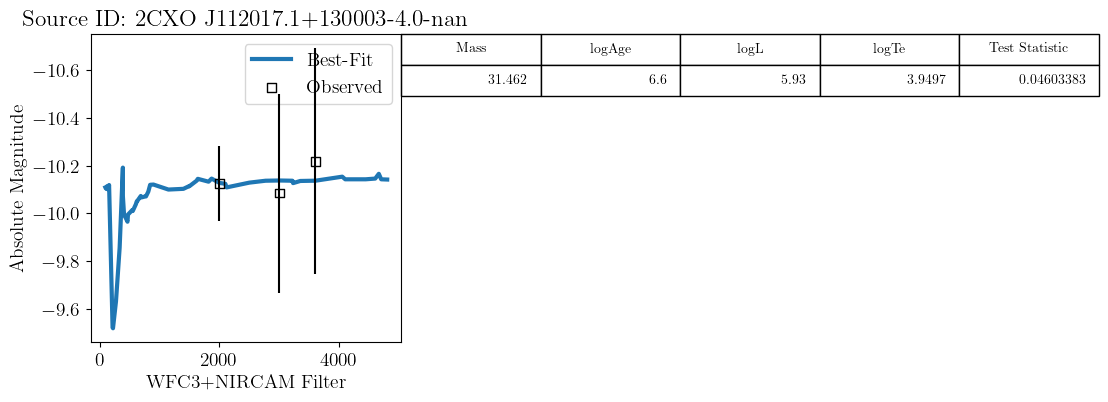

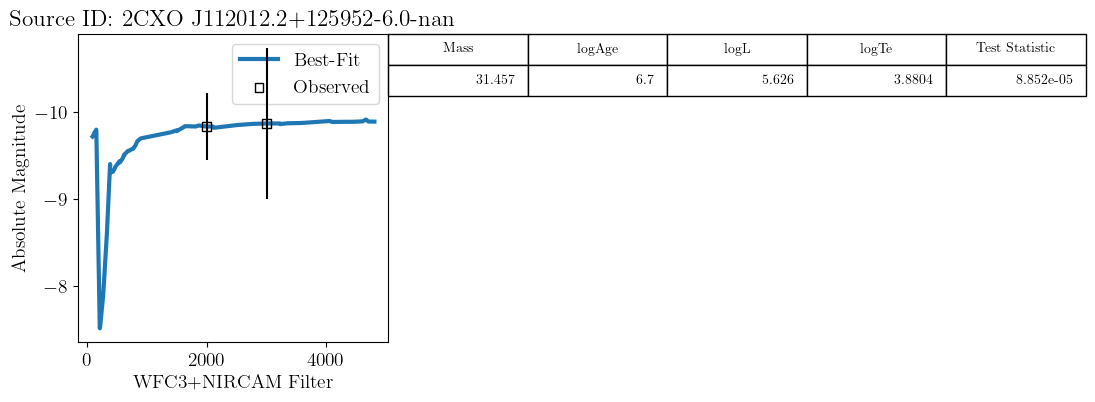

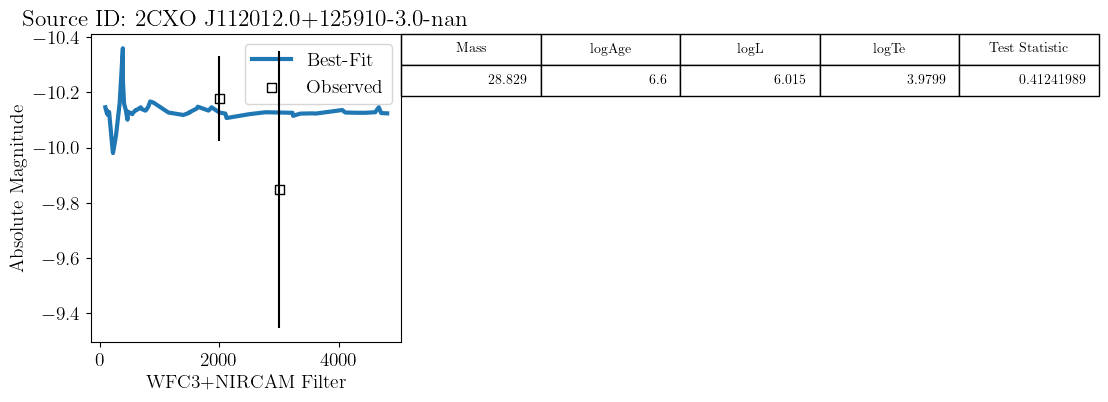

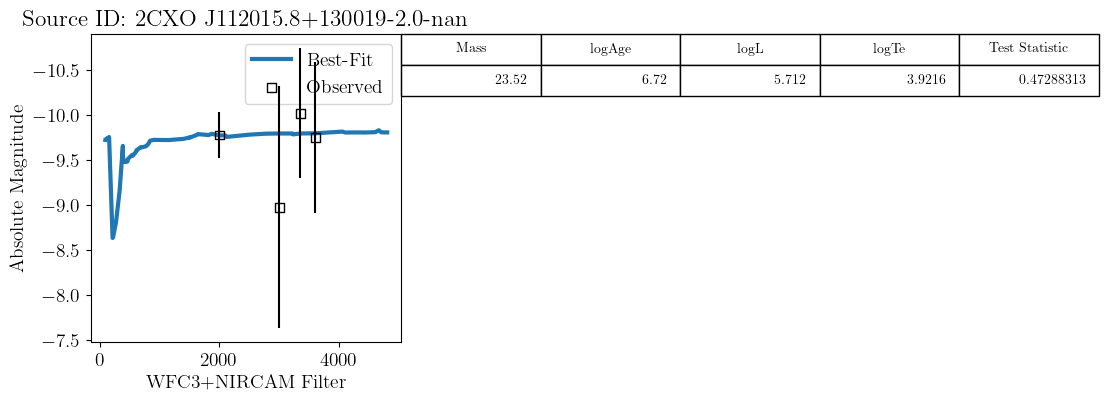

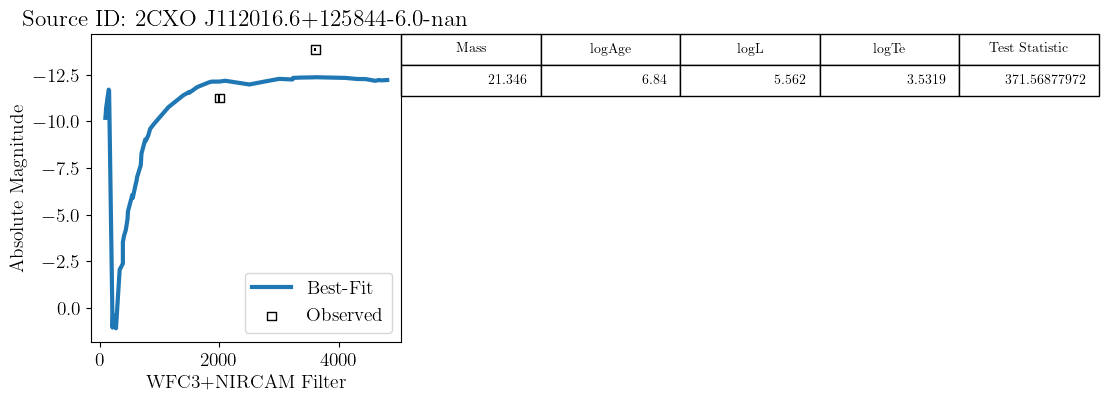

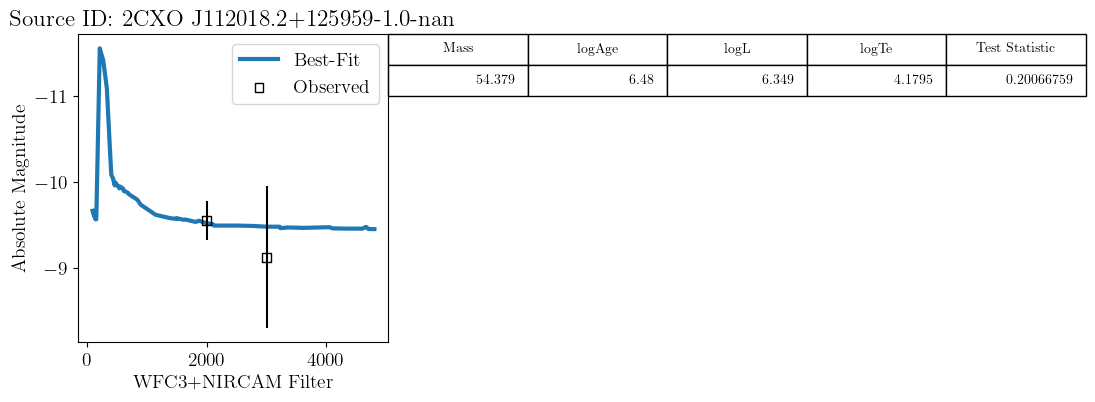

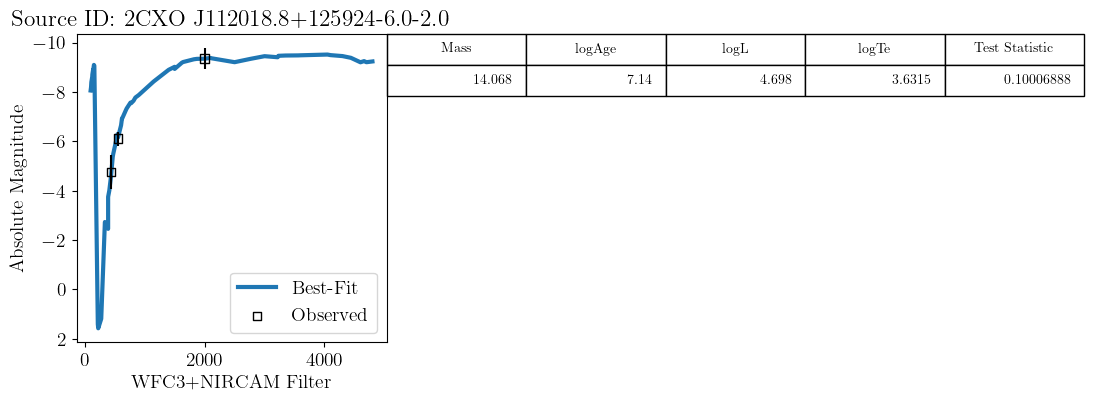

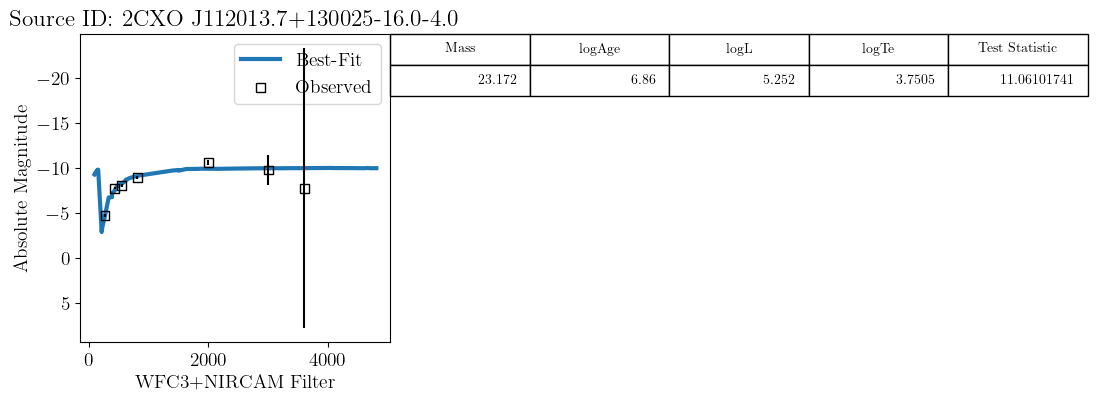

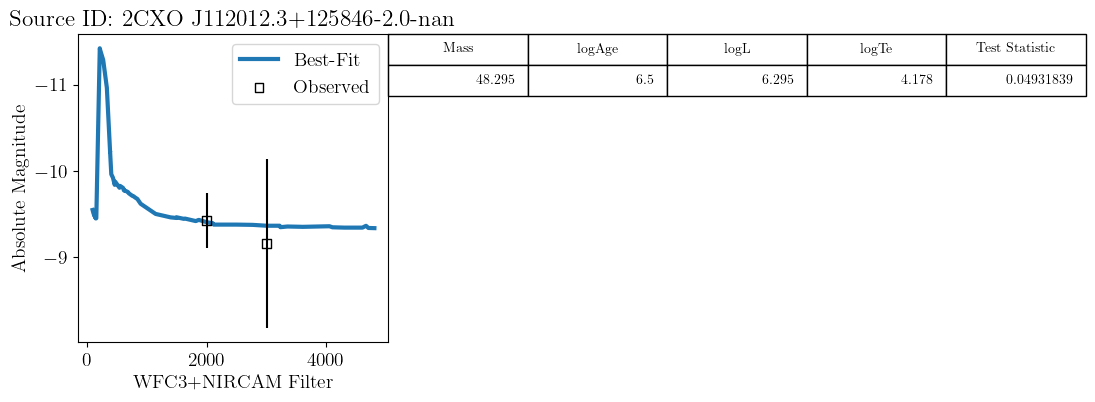

No best-fit model available for Source ID 2CXO J112011.3+125904-nan-nan.


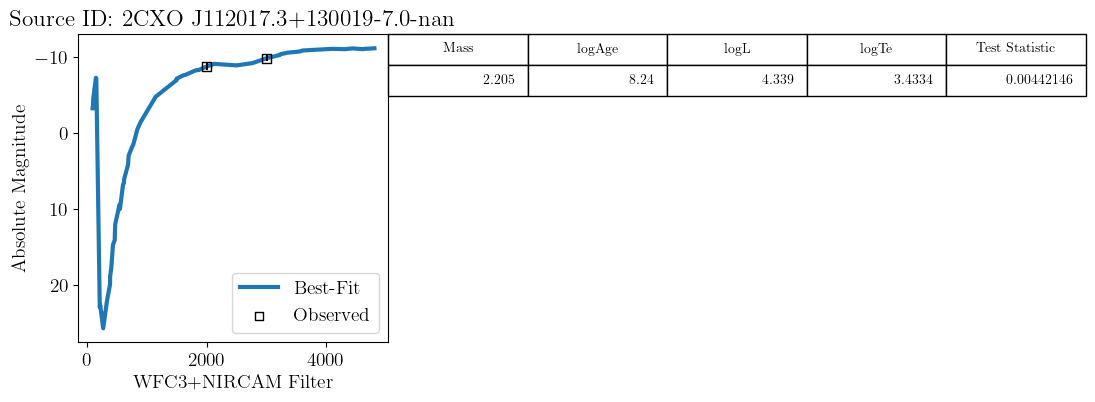

No best-fit model available for Source ID 2CXO J112017.6+130017-nan-nan.


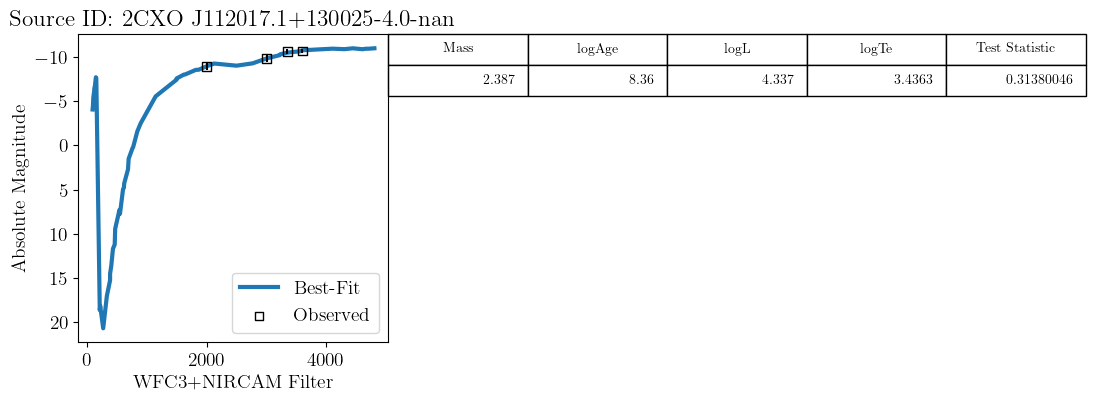

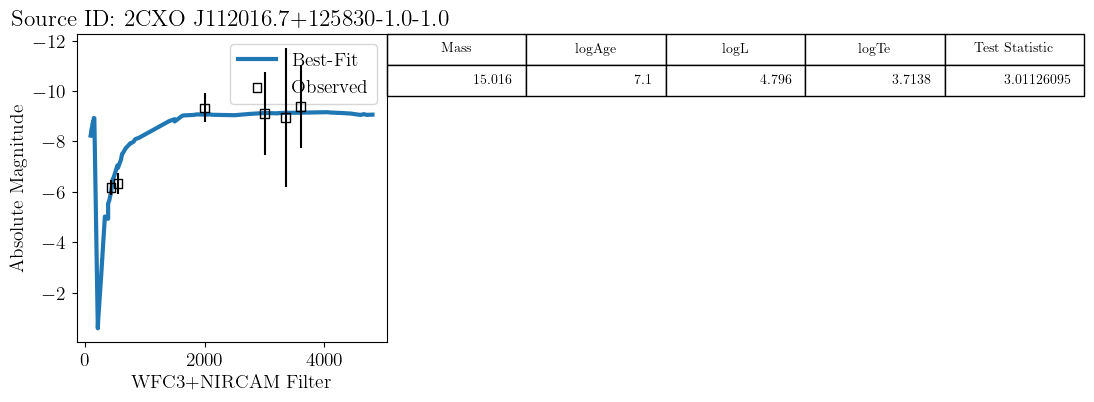

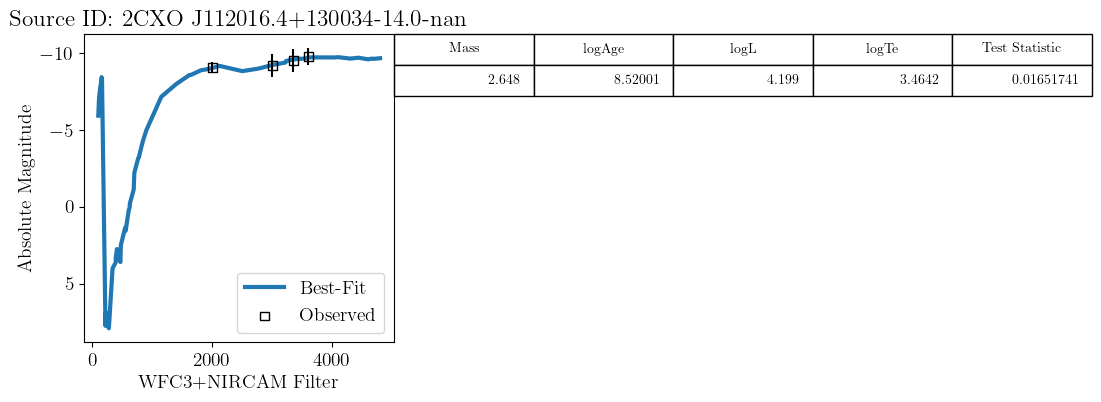

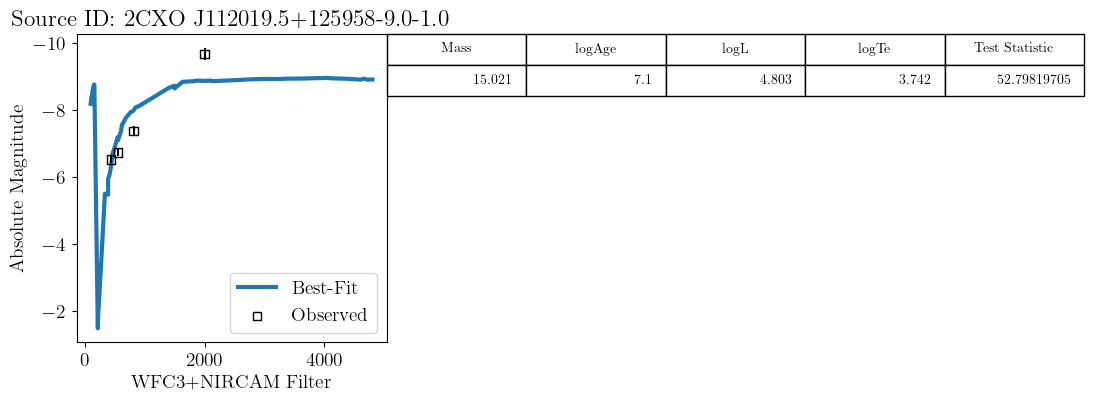

No best-fit model available for Source ID 2CXO J112018.7+130027-nan-nan.


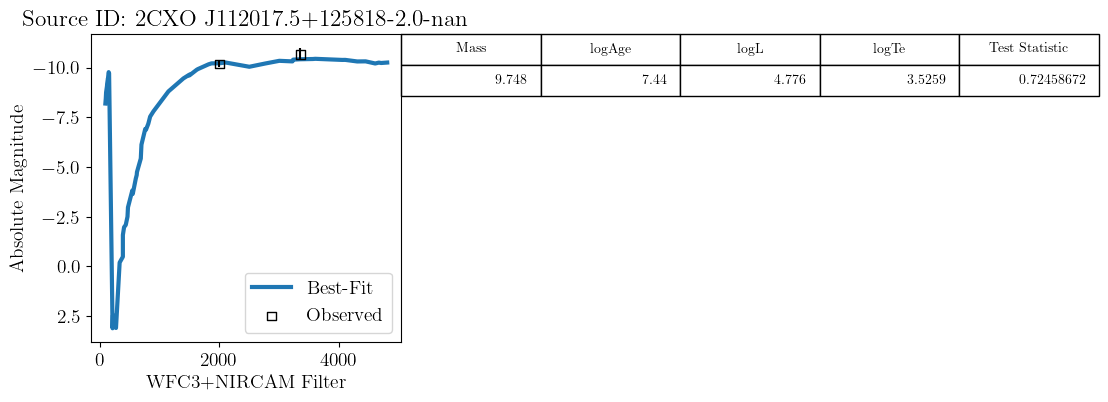

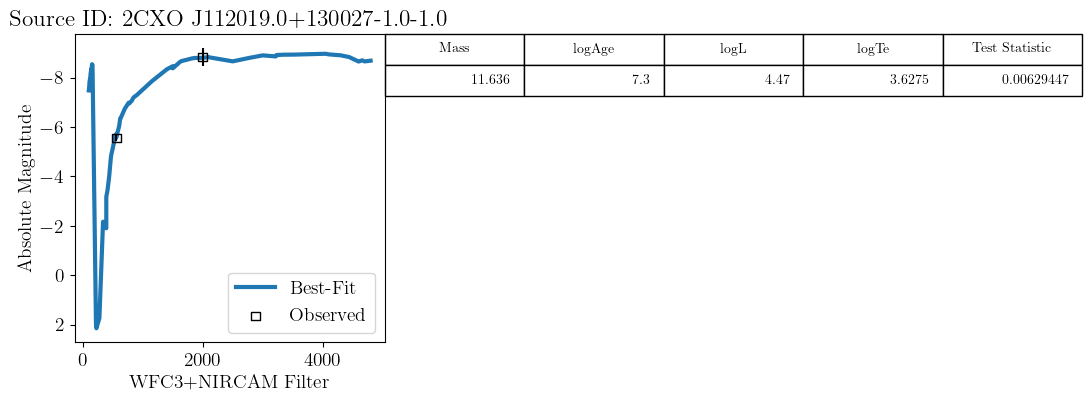

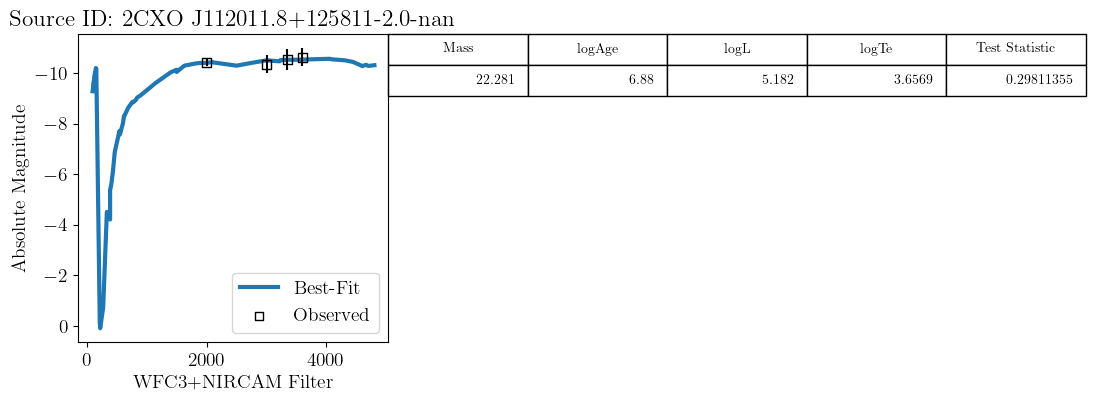

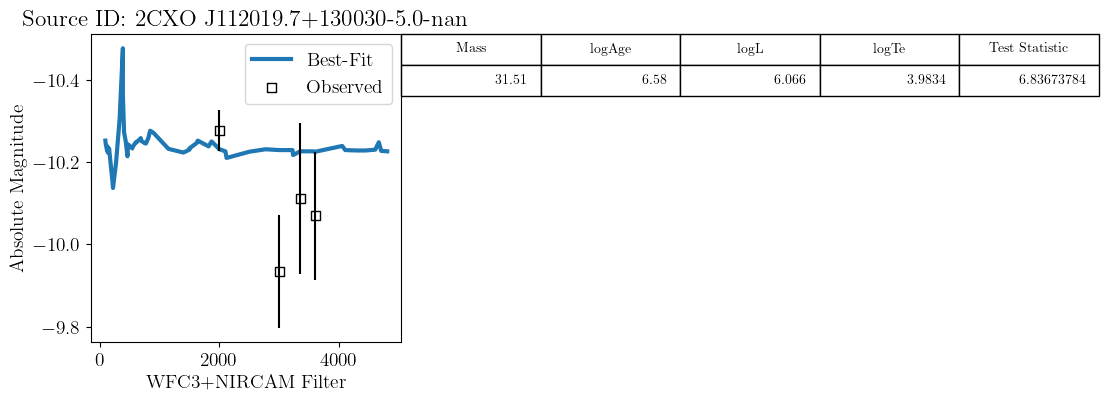

No best-fit model available for Source ID 2CXO J112019.6+125820-nan-nan.
No best-fit model available for Source ID 2CXO J112008.8+125853-nan-nan.
No best-fit model available for Source ID 2CXO J112014.9+130113-nan-nan.


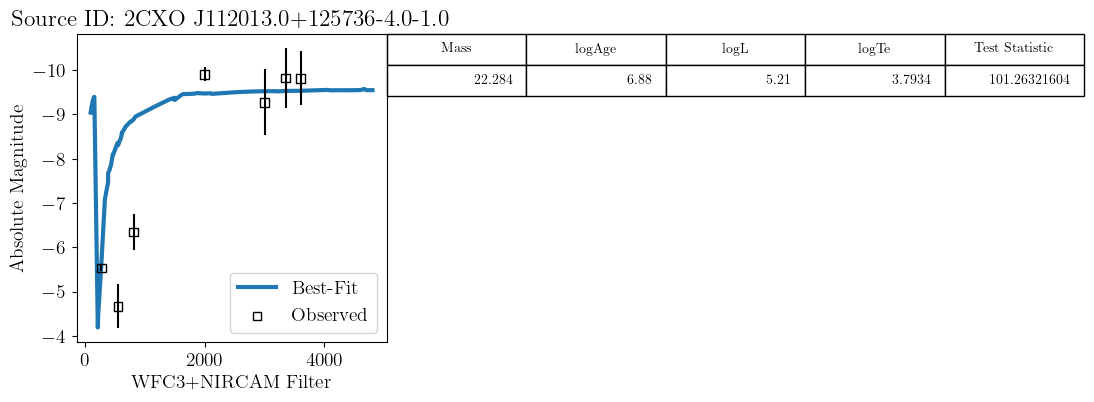

No best-fit model available for Source ID 2CXO J112015.9+125727-nan-2.0.
No best-fit model available for Source ID 2CXO J112018.9+130135-nan-nan.
No best-fit model available for Source ID 2CXO J112017.5+125644-nan-nan.


In [5]:
best_fit = FitSED(
    df=M66_xrbs,
    idheader='Auxiliary ID',
    instrument='wfc3+nircam',
    # min_models=5
)

In [6]:
# Add the useful information from SED fitting to the main df
tempfit = best_fit.copy()
tempfit = tempfit[[ 'Auxiliary ID', 'logAge', 'Mass', 'Test Statistic']]
tempfit['Stellar Age (Myr)'] = 10 ** tempfit['logAge'].values * u.yr.to(u.Myr)
tempfit = tempfit.rename(columns={'Mass': 'Star Mass (Myr)',
                                  'Test Statistic': 'SED Test Statistic'})
M66_xrbs = M66_xrbs.merge(tempfit, on='Auxiliary ID', how='left')

M66_xrbs

,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,Auxiliary ID,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr)
0,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,2CXO J112014.9+125933-3.0-2.0,6.68000,31.619,36.436988,4.786301
1,2CXO J112015.3+125932,CXO005,LMXB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112015.3+125932-nan-nan,NaN,NaN,NaN,NaN
2,2CXO J112015.0+125936,CXO006,HMXB,2.0,1.0,170.062808,12.993437,200852.0,46417.0,42593.0,48557.0,3048.131145,6003.004427,3700.317585,5908.701948,19792.0,NaN,NaN,36916.0,NaN,170.062784,12.993454,NaN,184.978557,-11.584072,-1.756274,-12.044657,-1.388903,-12.183175,-1.228733,NaN,NaN,NaN,1.142291,NaN,1.536468,NaN,NaN,2CXO J112015.0+125936-2.0-1.0,6.92000,19.610,0.057004,8.317638
3,2CXO J112015.0+125921,CXO007,HMXB,7.0,1.0,170.062475,12.989191,169350.0,39698.0,36199.0,41583.0,3086.128147,5505.907098,3727.624318,5519.646556,16435.0,NaN,NaN,NaN,NaN,170.062475,12.989172,NaN,13.846357,-10.932239,-2.894194,-11.094335,-2.970991,-11.154931,-2.804088,NaN,NaN,NaN,NaN,-6.695964,-2.693151,NaN,NaN,2CXO J112015.0+125921-7.0-1.0,6.88000,22.278,0.003592,7.585776
4,2CXO J112015.2+125921,CXO008,HMXB,7.0,3.0,170.063489,12.989460,171191.0,NaN,NaN,NaN,2970.358329,5537.339696,3640.754910,5546.285666,16686.0,NaN,NaN,NaN,NaN,170.063456,12.989465,-10.401179,-2.258856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.551823,-3.289136,NaN,NaN,2CXO J112015.2+125921-7.0-3.0,6.96000,19.088,0.000272,9.120108
5,2CXO J112014.7+125937,CXO009,HMXB,7.0,1.0,170.061275,12.993558,201863.0,NaN,NaN,NaN,3222.967034,6017.205864,3834.343555,5918.287693,19852.0,NaN,NaN,37022.0,NaN,170.061270,12.993559,-9.975986,-3.230107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.744178,-7.880962,-6.233019,-4.222578,NaN,NaN,2CXO J112014.7+125937-7.0-1.0,7.08000,15.293,0.001145,12.022644
6,2CXO J112015.0+125938,CXO010,HMXB,6.0,1.0,170.062865,12.993964,204900.0,NaN,NaN,NaN,3041.554415,6064.707748,3694.780748,5952.563551,20110.0,134991.0,NaN,NaN,NaN,170.062846,12.993936,-9.586088,-4.277069,NaN,NaN,NaN,NaN,NaN,NaN,-5.450522,-0.102546,NaN,NaN,-5.292991,-6.290347,NaN,NaN,2CXO J112015.0+125938-6.0-1.0,6.98000,18.409,0.199694,9.549926
7,2CXO J112014.2+125927,CXO011,LMXB,3.0,NaN,170.059328,12.990910,182257.0,42409.0,38745.0,44337.0,3445.041678,5707.156183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.365068,-0.780651,-9.906455,-2.639223,-10.491327,-1.836659,-10.608536,-1.645945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.2+125927-3.0-nan,7.40000,10.260,0.046999,25.118864
8,2CXO J112014.1+125923,CXO012,LMXB,3.0,NaN,170.058784,12.989716,173327.0,40534.0,36971.0,42428.0,3507.120121,5567.361186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.280691,-1.462720,-8.043054,-10.280138,-8.293276,-9.718285,-7.756413,-15.829940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.1+125923-3.0-nan,8.62001,1.309,0.023351,416.878982
9,2CXO J112014.3+125918,CXO013,LMXB,4.0,NaN,170.059730,12.988352,163096.0,38416.0,34983.0,NaN,3399.258592,5407.640929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.930437,-2.478914,-10.142517,-1.846408,-10.349826,-1.832567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.3+125918-4.0-nan,8.06000,2.699,0.023714,114.815362


## Find the best parent cluster

In [7]:
# Add CSC coordinates for finding the distances between clusters
M66_best = remove_unnamed(pd.read_csv(chandra_hst_dir+'M66_csc_bestrads.frame'))
temp = M66_best[['CSC ID', 'RA', 'Dec', '2Sig', '2Sig (pix)']]
temp = temp.rename(columns={
    'RA'         : 'CSC RA',
    'Dec'        : 'CSC Dec',
    '2Sig'       : '2 Sig (arcsec)',
    '2Sig (pix)' : '2 Sig (pix)'
})
M66_xrbs = M66_xrbs.merge(temp, on='CSC ID', how='left')

In [8]:
# 45.5 pc/arcsec
search_radius = 1000 / (3600 * 45.4)
print(f"Using search radius: {search_radius} deg")

Using search radius: 0.006118453255017132 deg


In [9]:
FindUnique(M66_xrbs, header='CSC ID')

,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,Auxiliary ID,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),CSC RA,CSC Dec,2 Sig (arcsec),2 Sig (pix)
0,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,2CXO J112014.9+125933-3.0-2.0,6.68000,31.619,36.436988,4.786301,170.062259,12.992633,0.235415,5.941826
1,2CXO J112015.3+125932,CXO005,LMXB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112015.3+125932-nan-nan,NaN,NaN,NaN,NaN,170.064119,12.992230,0.345133,8.711076
2,2CXO J112015.0+125936,CXO006,HMXB,2.0,1.0,170.062808,12.993437,200852.0,46417.0,42593.0,48557.0,3048.131145,6003.004427,3700.317585,5908.701948,19792.0,NaN,NaN,36916.0,NaN,170.062784,12.993454,NaN,184.978557,-11.584072,-1.756274,-12.044657,-1.388903,-12.183175,-1.228733,NaN,NaN,NaN,1.142291,NaN,1.536468,NaN,NaN,2CXO J112015.0+125936-2.0-1.0,6.92000,19.610,0.057004,8.317638,170.062785,12.993429,0.243913,6.156299
3,2CXO J112015.0+125921,CXO007,HMXB,7.0,1.0,170.062475,12.989191,169350.0,39698.0,36199.0,41583.0,3086.128147,5505.907098,3727.624318,5519.646556,16435.0,NaN,NaN,NaN,NaN,170.062475,12.989172,NaN,13.846357,-10.932239,-2.894194,-11.094335,-2.970991,-11.154931,-2.804088,NaN,NaN,NaN,NaN,-6.695964,-2.693151,NaN,NaN,2CXO J112015.0+125921-7.0-1.0,6.88000,22.278,0.003592,7.585776,170.062538,12.989251,0.467468,11.798781
4,2CXO J112015.2+125921,CXO008,HMXB,7.0,3.0,170.063489,12.989460,171191.0,NaN,NaN,NaN,2970.358329,5537.339696,3640.754910,5546.285666,16686.0,NaN,NaN,NaN,NaN,170.063456,12.989465,-10.401179,-2.258856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.551823,-3.289136,NaN,NaN,2CXO J112015.2+125921-7.0-3.0,6.96000,19.088,0.000272,9.120108,170.063419,12.989393,0.375305,9.472610
5,2CXO J112014.7+125937,CXO009,HMXB,7.0,1.0,170.061275,12.993558,201863.0,NaN,NaN,NaN,3222.967034,6017.205864,3834.343555,5918.287693,19852.0,NaN,NaN,37022.0,NaN,170.061270,12.993559,-9.975986,-3.230107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.744178,-7.880962,-6.233019,-4.222578,NaN,NaN,2CXO J112014.7+125937-7.0-1.0,7.08000,15.293,0.001145,12.022644,170.061339,12.993597,0.465134,11.739872
6,2CXO J112015.0+125938,CXO010,HMXB,6.0,1.0,170.062865,12.993964,204900.0,NaN,NaN,NaN,3041.554415,6064.707748,3694.780748,5952.563551,20110.0,134991.0,NaN,NaN,NaN,170.062846,12.993936,-9.586088,-4.277069,NaN,NaN,NaN,NaN,NaN,NaN,-5.450522,-0.102546,NaN,NaN,-5.292991,-6.290347,NaN,NaN,2CXO J112015.0+125938-6.0-1.0,6.98000,18.409,0.199694,9.549926,170.062887,12.993977,0.343588,8.672081
7,2CXO J112014.2+125927,CXO011,LMXB,3.0,NaN,170.059328,12.990910,182257.0,42409.0,38745.0,44337.0,3445.041678,5707.156183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.365068,-0.780651,-9.906455,-2.639223,-10.491327,-1.836659,-10.608536,-1.645945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.2+125927-3.0-nan,7.40000,10.260,0.046999,25.118864,170.059380,12.990875,0.228792,5.774667
8,2CXO J112014.1+125923,CXO012,LMXB,3.0,NaN,170.058784,12.989716,173327.0,40534.0,36971.0,42428.0,3507.120121,5567.361186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.280691,-1.462720,-8.043054,-10.280138,-8.293276,-9.718285,-7.756413,-15.829940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.1+125923-3.0-nan,8.62001,1.309,0.023351,416.878982,170.058772,12.989771,0.361474,9.123531
9,2CXO J112014.3+125918,CXO013,LMXB,4.0,NaN,170.059730,12.988352,163096.0,38416.0,34983.0,NaN,3399.258592,5407.640929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.930437,-2

In [10]:
region = M66_dir+'phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg'
catalog = 'Cluster'
search_radius = search_radius

distances = calculate_distance(
    df=M66_xrbs,
    regions=region,
    catalogs=catalog,
    imagefilename=f555w,
    search_radius=search_radius,
    coordsys='fk5',
    coordheads=['CSC RA', 'CSC Dec'],
    # instrument is used for using the FWHM. I am using WFC3's fwhm for all my work
    instrument='wfc3',
    sourceid='Auxiliary ID'
)
distances

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...
Crossrefing done...
Done! Calculated Distances...


,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km)
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6740,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.061849,12.987713,17.769856,808.528449,2.494858e+16
1,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6788,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.061836,12.987976,16.830950,765.808229,2.363037e+16
2,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6969,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.058290,12.988918,19.306475,878.444618,2.710597e+16
3,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7009,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.057680,12.989119,20.444914,930.243609,2.870432e+16
4,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7020,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.058557,12.989210,17.902603,814.568423,2.513496e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,170.072915,12.945547,2CXO J112017.5+125644-nan-nan,476,2CXO J112017.5+125644,CXO072,LMXB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.369854,9.335036,170.075207,12.950529,19.656259,894.359763,2.759706e+16
4170,170.072915,12.945547,2CXO J112017.5+125644-nan-nan,489,2CXO J112017.5+125644,CXO072,LMXB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.369854,9.335036,170.073318,12.950664,18.473300,840.535151,2.593620e+16
4171,170.072915,12.945547,2CXO J112017.5+125644-nan-nan,515,2CXO J112017.5+125644,CXO072,LMXB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,n

### Gather all the cluster data from Phangs catalog

In [11]:
clustercat = pd.read_csv(M66_dir+'phangsclass12clustercandidatecatalogswithsizes/ngc3627_class12_w_sizes.csv')

# PHANGS provide their coordinates in ICRS. Convert to FK5
ra, dec = clustercat['PHANGS_RA'].values, clustercat['PHANGS_DEC'].values
fk5 = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs').transform_to(FK5)
ra_fk5, dec_fk5 = fk5.ra.deg, fk5.dec.deg
clustercat['RA'] = ra
clustercat['Dec'] = dec
 
# add the cluster masses, ages and info to the main dataframe
clustercat = clustercat[[
    # 'RA', 'Dec',
    'ID_PHANGS_CLUSTERS',
    'PHANGS_CI', 
    'PHANGS_AGE_MINCHISQ',
    'PHANGS_AGE_MINCHISQ_ERR', 
    'PHANGS_MASS_MINCHISQ',
    'PHANGS_MASS_MINCHISQ_ERR', 
    'PHANGS_EBV_MINCHISQ',
    'PHANGS_EBV_MINCHISQ_ERR', 
    'PHANGS_REDUCED_MINCHISQ',
    'fwhm', 'r_eff(pix)', 
    'r_eff(arcsec)', 'r_eff(pc)'
]] 

# Rename headers to make everything consistent
clustercat = clustercat.rename(columns={
    'ID_PHANGS_CLUSTERS'       : 'Cluster ID',
    # 'RA': 'Cluster RA', 'Dec' : 'Cluster Dec',
    'PHANGS_CI'                : 'Cluster CI',
    'PHANGS_AGE_MINCHISQ'      : 'Cluster Age (Myr)',
    'PHANGS_AGE_MINCHISQ_ERR'  : 'Cluster Age Err (Myr)',
    'PHANGS_MASS_MINCHISQ'     : 'Cluster Mass (M_sun)',
    'PHANGS_MASS_MINCHISQ_ERR' : 'Cluster Mass Err (M_sun)',
    'PHANGS_EBV_MINCHISQ'      : 'Cluster EBV',
    'PHANGS_EBV_MINCHISQ_ERR'  : 'Cluster EBV Err',
    'PHANGS_REDUCED_MINCHISQ'  : 'Cluster Test Statistic',
    'fwhm'                     : 'Cluster FWHM',
    'r_eff(pix)'               : 'Cluster Radius Eff (pix)',
    'r_eff(arcsec)'            : 'Cluster Radius Eff (arcsec)',
    'r_eff(pc)'                : 'Cluster Radius Eff (pc)'
})

clustercat

,Cluster ID,Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc)
0,14,1.440696,1.0,1.0,8719.629994,2694.287932,0.31,0.04,0.155719,0.48,0.7104,0.028416,1.556879
1,46,1.652545,2440.0,1412.0,435789.158150,132243.181503,0.15,0.17,0.675790,1.32,1.9536,0.078144,4.281416
2,55,1.554934,182.0,28.0,17467.385090,2360.828542,0.00,0.01,0.798219,0.96,1.4208,0.056832,3.113757
3,68,1.723422,210.0,0.0,80145.110419,9281.609214,0.01,0.03,0.181574,1.55,2.2940,0.091760,5.027420
4,90,1.869660,500.0,151.0,55569.664342,1130.107884,0.00,0.10,0.702583,2.50,3.7000,0.148000,8.108742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,10668,1.837798,1028.0,625.0,15243.314080,6490.579020,0.04,0.37,0.141133,1.32,1.9536,0.078144,4.281416
2708,10670,1.626464,5.0,2.0,8629.588626,2126.057035,0.92,0.13,0.060492,1.18,1.7464,0.069856,3.827326
2709,10671,1.739450,118.0,347.0,11339.952560,1688.263020,0.35,0.24,0.026141,1.55,2.2940,0.091760,5.027420
2710,10672,1.906561,667.0,557.0,15856.958755,2760.559736,0.08,0.33,0.046162,3.09,4.5732,0.182928,10.022406


In [12]:
# merge cluster info with the main df
distances = distances.merge(clustercat, on=['Cluster ID'], how='left')
distances

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc)
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6740,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.061849,12.987713,17.769856,808.528449,2.494858e+16,1.613909,5.0,153.0,32159.451166,67739.414328,0.80,0.50,23.386633,0.96,1.4208,0.056832,3.113757
1,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6788,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.061836,12.987976,16.830950,765.808229,2.363037e+16,1.423196,890.0,120.0,174363.656114,17070.864641,0.00,0.01,3.086535,0.39,0.5772,0.023088,1.264964
2,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6969,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.058290,12.988918,19.306475,878.444618,2.710597e+16,1.750547,500.0,77.0,69972.213290,11389.178992,0.10,0.09,1.464285,1.91,2.8268,0.113072,6.195079
3,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7009,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.057680,12.989119,20.444914,930.243609,2.870432e+16,1.763707,158.0,48.0,206060.938059,14694.145980,0.01,0.09,0.208602,1.91,2.8268,0.113072,6.195079
4,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7020,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.058557,12.989210,17.902603,814.568423,2.513496e+16,1.750742,110.0,34.0,43030.350062,573.446002,0.26,0.07,0.680461,2.36,3.4928,0.139712,7.654653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,170.072915,12.945547,2CXO J112017.5+125644-nan-nan,476,2CXO J112017.5+125644,CXO072,LMXB,n

### Select the best parent cluster

I am still testing out an algorithm to select the best parent-star cluster. Currently, I have two algorithms, one with the standard weighted least squares fitting, but we are afraid that it might giving a little too much weightage to the errors in the age. The PHANGS collaboration have exceptionally high error in the cluster ages, which completely blotches some parts of my analysis. 

I have designed another algorithm within the same code that gives a lesser weightage to the errors, while placing a higher importance for the distances between the XRB and the cluster. Perhaps that might be a better way to judge this. 

In [13]:
dists = distances.copy()
dists.to_csv('/Users/undergradstudent/Downloads/temp.csv')
dists = remove_unnamed(pd.read_csv('/Users/undergradstudent/Downloads/temp.csv'))

In [14]:
potential_clusters = find_parent_cluster(df=dists, fit_type='updated wls',
                                     star_age_head='Stellar Age (Myr)')
potential_clusters

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),XRB-Parent Test Statistic
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6740,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.061849,12.987713,17.769856,808.528449,2.494858e+16,1.613909,5.0,153.0,32159.451166,67739.414328,0.80,0.50,23.386633,0.96,1.4208,0.056832,3.113757,2.413288e-01
1,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6788,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.061836,12.987976,16.830950,765.808229,2.363037e+16,1.423196,890.0,120.0,174363.656114,17070.864641,0.00,0.01,3.086535,0.39,0.5772,0.023088,1.264964,5.000749e+06
2,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6969,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.058290,12.988918,19.306475,878.444618,2.710597e+16,1.750547,500.0,77.0,69972.213290,11389.178992,0.10,0.09,1.464285,1.91,2.8268,0.113072,6.195079,2.797750e+06
3,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7009,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.057680,12.989119,20.444914,930.243609,2.870432e+16,1.763707,158.0,48.0,206060.938059,14694.145980,0.01,0.09,0.208602,1.91,2.8268,0.113072,6.195079,4.549364e+05
4,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7020,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.058557,12.989210,17.902603,814.568423,2.513496e+16,1.750742,110.0,34.0,43030.350062,573.446002,0.26,0.07,0.680461,2.36,3.4928,0.139712,7.654653,2.652120e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
candidate_clusters = find_parent_cluster(df=dists, fit_type='wls',
                                     star_age_head='Stellar Age (Myr)')
candidate_clusters

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),XRB-Parent Test Statistic
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6740,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.061849,12.987713,17.769856,808.528449,2.494858e+16,1.613909,5.0,153.0,32159.451166,67739.414328,0.80,0.50,23.386633,0.96,1.4208,0.056832,3.113757,0.000002
1,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6788,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.061836,12.987976,16.830950,765.808229,2.363037e+16,1.423196,890.0,120.0,174363.656114,17070.864641,0.00,0.01,3.086535,0.39,0.5772,0.023088,1.264964,54.416895
2,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6969,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.058290,12.988918,19.306475,878.444618,2.710597e+16,1.750547,500.0,77.0,69972.213290,11389.178992,0.10,0.09,1.464285,1.91,2.8268,0.113072,6.195079,41.362221
3,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7009,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.057680,12.989119,20.444914,930.243609,2.870432e+16,1.763707,158.0,48.0,206060.938059,14694.145980,0.01,0.09,0.208602,1.91,2.8268,0.113072,6.195079,10.188558
4,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7020,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68,31.619,36.436988,4.786301,0.235415,5.941826,170.058557,12.989210,17.902603,814.568423,2.513496e+16,1.750742,110.0,34.0,43030.350062,573.446002,0.26,0.07,0.680461,2.36,3.4928,0.139712,7.654653,9.576058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,170.072915,1

In [ ]:
# Select only the cluster with the lowest test statistic
def choose_xrb_cluster(df):
    '''Finds the xrb- cluster with the smallest test statistic'''
    xrb_cluster = pd.DataFrame()
    for cscid in FindUnique(df, header='CSC ID')['CSC ID'].tolist():
        temp = Find(candidate_clusters, f'CSC ID = {cscid}')
        test_stat = temp['XRB-Parent Test Statistic'].min()
        cluster = Find(temp, f'XRB-Parent Test Statistic == {test_stat}').iloc[[0]]
        xrb_cluster = pd.concat([xrb_cluster, cluster])

    xrb_cluster = xrb_cluster.reset_index(drop=True)
    return xrb_cluster

xrb_cluster = choose_xrb_cluster(candidate_clusters)
xrb_cluster

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),XRB-Parent Test Statistic
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6790,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68000,31.619,36.436988,4.786301,0.235415,5.941826,170.062151,12.988011,16.642396,757.229005,2.336565e+16,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,6.835494e-07
1,170.064119,12.992230,2CXO J112015.3+125932-nan-nan,6723,2CXO J112015.3+125932,CXO005,LMXB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345133,8.711076,170.067187,12.987615,19.794005,900.627249,2.779045e+16,1.408762,3.0,1.0,8546.019197,3766.361045,0.28,0.05,0.409133,0.39,0.5772,0.023088,1.264964,NaN
2,170.062785,12.993429,2CXO J112015.0+125936-2.0-1.0,6790,2CXO J112015.0+125936,CXO006,HMXB,2.0,1.0,170.062808,12.993437,200852.0,46417.0,42593.0,48557.0,3048.131145,6003.004427,3700.317585,5908.701948,19792.0,NaN,NaN,36916.0,NaN,170.062784,12.993454,NaN,184.978557,-11.584072,-1.756274,-12.044657,-1.388903,-12.183175,-1.228733,NaN,NaN,NaN,1.142291,NaN,1.536468,NaN,NaN,6.92000,19.610,0.057004,8.317638,0.243913,6.156299,170.062151,12.988011,19.630307,893.178958,2.756062e+16,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,2.492522e-06
3,170.062538,12.989251,2CXO J112015.0+125921-7.0-1.0,6790,2CXO J112015.0+125921,CXO007,HMXB,7.0,1.0,170.062475,12.989191,169350.0,39698.0,36199.0,41583.0,3086.128147,5505.907098,3727.624318,5519.646556,16435.0,NaN,NaN,NaN,NaN,170.062475,12.989172,NaN,13.846357,-10.932239,-2.894194,-11.094335,-2.970991,-11.154931,-2.804088,NaN,NaN,NaN,NaN,-6.695964,-2.693151,NaN,NaN,6.88000,22.278,0.003592,7.585776,0.467468,11.798781,170.062151,12.988011,4.664836,212.250051,6.549352e+15,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,1.166894e-06
4,170.063419,12.989393,2CXO J112015.2+125921-7.0-3.0,6790,2CXO J112015.2+125921,CXO008,HMXB,7.0,3.0,170.063489,12.989460,171191.0,NaN,NaN,NaN,2970.358329,5537.339696,3640.754910,5546.285666,16686.0,NaN,NaN,NaN,NaN,170.063456,12.989465,-10.401179,-2.258856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.551823,-3.289136,NaN,NaN,6.96000,19.088,0.000272,9.120108,0.375305,9.472610,170.062151,12.988011,6.675101,303.717083,9.371730e+15,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,4.517387e-06
5,170.061339,12.993597,2CXO J112014.7+125937-7.0-1.0,6790,2CXO J112014.7+125937,CXO009,HMXB,7.0,1.0,170.061275,12.993558,201863.0,NaN,NaN,NaN,3222.967034,6017.205864,3834.343555,5918.287693,19852.0,NaN,NaN,37022.0,NaN,170.061270,12.993559,-9.975986,-3.230107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.744178,-7.880962,-6.233019,-4.222578,NaN,NaN,7.08000,15.293,0.001145,12.022644,0.465134,11.739872,170.062151,12.988011,20.308482,924.035919,2.851277e+16,2.085138,6.0,1468.0,62313.249481,580

## Determine which cluster parent identification algorithm to use

In [268]:
cscid = M66_xrbs['CSC ID'].tolist()[34]
test = Find(candidate_clusters, f'CSC ID == {cscid}')
test = test.sort_values(by='XRB-Parent Test Statistic').reset_index(drop=True).iloc[:20]
print('########## Using the original WLS ################')
display(test[['CSC ID', 'Cluster ID', 'Stellar Age (Myr)','Cluster Age (Myr)', 'Cluster Age Err (Myr)',
      'Cluster Separation (pc)', 'XRB-Parent Test Statistic']])

temp = Find(potential_clusters, f'CSC ID == {cscid}')
temp = temp.sort_values(by='XRB-Parent Test Statistic').reset_index(drop=True).iloc[:20]
print("######### Using Updated WLS #################")
display(temp[['CSC ID', 'Cluster ID', 'Stellar Age (Myr)','Cluster Age (Myr)', 'Cluster Age Err (Myr)',
      'Cluster Separation (pc)', 'XRB-Parent Test Statistic']])

########## Using the original WLS ################


,CSC ID,Cluster ID,Stellar Age (Myr),Cluster Age (Myr),Cluster Age Err (Myr),Cluster Separation (pc),XRB-Parent Test Statistic
0,2CXO J112016.4+130034,9783,331.138746,302.0,5491.0,336.425060,0.000028
1,2CXO J112016.4+130034,10479,331.138746,577.0,5216.0,975.434425,0.002222
2,2CXO J112016.4+130034,10158,331.138746,375.0,370.0,647.260181,0.014053
3,2CXO J112016.4+130034,10248,331.138746,302.0,231.0,853.273578,0.015912
4,2CXO J112016.4+130034,9389,331.138746,403.0,401.0,691.244556,0.032114
5,2CXO J112016.4+130034,10243,331.138746,375.0,149.0,318.883159,0.086654
6,2CXO J112016.4+130034,9200,331.138746,465.0,370.0,930.461199,0.130890
7,2CXO J112016.4+130034,9314,331.138746,281.0,134.0,833.478304,0.140003
8,2CXO J112016.4+130034,10211,331.138746,465.0,305.0,158.120665,0.192624
9,2CXO J112016.4+130034,10295,331.138746,243.0,177.0,588.892426,0.247963


######### Using Updated WLS #################


,CSC ID,Cluster ID,Stellar Age (Myr),Cluster Age (Myr),Cluster Age Err (Myr),Cluster Separation (pc),XRB-Parent Test Statistic
0,2CXO J112016.4+130034,9783,331.138746,302.0,5491.0,336.425060,52.020990
1,2CXO J112016.4+130034,10248,331.138746,302.0,231.0,853.273578,3136.303173
2,2CXO J112016.4+130034,10158,331.138746,375.0,370.0,647.260181,3365.419844
3,2CXO J112016.4+130034,10234,331.138746,302.0,47.0,202.156814,3652.012417
4,2CXO J112016.4+130034,10243,331.138746,375.0,149.0,318.883159,4117.251542
5,2CXO J112016.4+130034,9419,331.138746,349.0,26.0,710.867039,8722.458574
6,2CXO J112016.4+130034,9389,331.138746,403.0,401.0,691.244556,8901.781549
7,2CXO J112016.4+130034,10211,331.138746,465.0,305.0,158.120665,9289.633289
8,2CXO J112016.4+130034,10479,331.138746,577.0,5216.0,975.434425,11304.222057
9,2CXO J112016.4+130034,9314,331.138746,281.0,134.0,833.478304,15636.388017


In [183]:
temp

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),XRB-Parent Test Statistic
0,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,3645,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.072664,12.976778,11.555242,525.763515,1.622337e+16,1.615210,13.0,19.0,8856.970033,9679.842947,0.37,0.03,1.836022,0.96,1.4208,0.056832,3.113757,4.668564
1,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,2525,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.072278,12.972309,12.853502,584.834337,1.804610e+16,1.602000,12.0,4.0,1493.504590,414.448011,0.25,0.05,3.020511,1.91,2.8268,0.113072,6.195079,50.766605
2,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,4070,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.070305,12.977870,10.326890,469.873481,1.449878e+16,1.739883,7.0,54.0,13064.151489,27613.909507,0.33,0.26,0.687483,1.55,2.2940,0.091760,5.027420,271.828435
3,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,3824,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.071586,12.977280,10.030666,456.395282,1.408289e+16,1.844182,5.0,83.0,6427.987350,16387.325276,0.66,0.34,1.068700,3.75,5.5500,0.222000,12.163114,316.709612
4,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,2314,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.068838,12.970881,15.389090,700.203595,2.160603e+16,1.639200,6.0,89.0,1167.345883,4908.854948,0.40,0.23,0.602299,1.18,1.7464,0.069856,3.827326,341.591333
5,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,3724,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,1

In [182]:
potential_clusters.query('`CSC ID` == "2CXO J112016.7+125830"')

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),XRB-Parent Test Statistic
3094,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,2315,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.068625,12.970887,15.567620,708.326702,2.185668e+16,1.563225,66.0,9.0,19128.737975,2593.332441,0.04,0.01,1.068471,0.96,1.4208,0.056832,3.113757,2.245166e+05
3095,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,2375,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.067725,12.971398,15.136576,688.714199,2.125150e+16,1.395917,127.0,17.0,34194.770792,4469.739977,0.00,0.06,0.281033,0.39,0.5772,0.023088,1.264964,5.303026e+05
3096,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,2477,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.073955,12.971956,18.010777,819.490341,2.528683e+16,1.960916,403.0,160.0,50144.757922,6226.239768,0.18,0.08,0.179660,4.92,7.2816,0.291264,15.958005,7.806698e+05
3097,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,2510,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.070374,12.972196,10.328338,469.939385,1.450081e+16,1.603832,24.0,16.0,34548.048856,17638.886314,0.42,0.14,1.285284,1.32,1.9536,0.078144,4.281416,3.824282e+03
3098,170.069903,12.975028,2CXO J112016.7+125830-1.0-1.0,2570,2CXO J112016.7+125830,CXO044,HMXB,1.0,1.0,170.069948,12.974921,79731.0,19653.0,17375.0,20801.0,2233.583519,3835.162196,3067.397243,4222.603316,5919.0,NaN,66663.0,16517.0,NaN,170.069932,12.974897,-9.329462,-0.576828,-9.106587,-1.638459,-8.940307,-2.754479,-9.38324,-1.64572,NaN,NaN,-6.160134,-0.295242,-6.319988,-0.412467,NaN,NaN,7.1,15.016,3.011261,12.589254,0.542665,13.696748,170.069289,12.972527,9.257226,421.203789,1.299699e+16,1.780957,169.0,33.0,27835.024388,2218.562082,0.09,0.07,0.728098,2.14,3.1672,0.126688,6.941083,3.122565e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [184]:
from helpers.regions import make_regions
temp['Distances'] = np.round(temp['Cluster Separation (pc)'].values, 0)

# Make vector regions
make_regions(sources=temp, hdu=f555w, outfile='/Users/undergradstudent/Downloads/xrb_cluster_temp.reg',
             reg_type='vector',
             coordsys='fk5', coordheads=['JWST RA', 'JWST Dec'],
             additional_coords=['Cluster RA', 'Cluster Dec'],
             idheader='Distances')

# Make regions around clusters
WriteReg(
    sources=temp,
    outfile='/Users/undergradstudent/Downloads/clusters_temp.reg',
    idheader='Cluster Age (Myr)',
    coordsys='fk5',
    coordheads=['Cluster RA', 'Cluster Dec'],
    radius=0.05,
    radunit='arcsec'
)

Saving /Users/undergradstudent/Downloads/xrb_cluster_temp.reg
/Users/undergradstudent/Downloads/xrb_cluster_temp.reg saved!
Saving /Users/undergradstudent/Downloads/clusters_temp.reg
/Users/undergradstudent/Downloads/clusters_temp.reg saved!


# Calculate Velocities

In [17]:
import itertools

def CalcEjection(df, cluster_age, cluster_rad, cluster_mass, xrb_mass, dist, m_avg=0.4, N_int=20): 
    """
    Calculates the absolute minimum and approximate maximum velocities of XRBs ejected from 
    nearby clusters, given the age, radius, and mass of the cluster, mass of the XRB donor star, 
    and distance between the cluster and XRB.
    
    The maximum velocity is calculated based on which ejection mechanism minimizes
    the travel time of the XRB given the cluster parameters: natal kicks, or 
    single-binary (3-body) interactions. These are based on the maximum formation 
    time of a compact object, or the ejection time following a series of strong 
    interactions.
    
    Make sure the age of the cluster and age of the star are in the same units. 
    Distance between the XRB and cluster should be in [UNITS].
    
    PARAMETERS:
    -----------
    cluster_age [float]    :    Age of the parent cluster, in Myrs
    cluster_rad [float]    :    Radius of the parent cluster, in parsecs
    cluster_mass[float]    :    Mass of the parent cluster, in Msun
    xrb_mass    [float]    :    Mass of the XRB donor star, in Msun
    dist        [float]    :    Distance between the cluster and XRB in parsecs.
    m_avg       [float]    :    Average mass of the star in the cluster. Default is 
                                0.4 Msun, based on the Kroupa 2001 IMF. 
    N_int       [int]      :    Number of single-binary interactions required before
                                the XRB is ejected from the cluster. Default is 20.
    """
    
    df = df.copy()

    # UNITS
    Myr2sec = 3.1536e13 # Multiply Myr by Myr2sec to get time in secs
    sec2Myr = 1./Myr2sec
    pc2km = 3.086e13    # Multiply pc by pc2km to get km
    km2pc = 1./pc2km
    pc2au = 206265  # multiply pc by pc2au to get au
    au2pc = 1./pc2au
    
    # Gravitational constant
    # G = 6.6743e-11 # m^3 / km / s^2
    G_astro = 4.3009e-3 # in pc(km/s)^2/Msun or 1.908e5 in (km/s)^2*Rsun/Msun

    
    #############################################################
    #####   CALCULATION OF THE MAXIMUM VELOCITY OF THE XRB  #####
    #############################################################  
    
    # units km/s
    vmin = (dist*pc2km) / (cluster_age*Myr2sec)
    
    #############################################################
    ##### CALCULATION OF THE COMPACT OBJECT FORMATION TIME  #####
    #############################################################
    
    # Time of CO formation assumes CO formed from 8Msun star 
    # and takes and additional 1 Myr to complete metal burning
    
    # Calculate a mesh of stellar masses between 8-200Msun
    # Determine which gives the longest Tco without exceeding the
    # age of the cluster
    for m in range(200,7,-1):
        Tco_m = (1e10*(m)**(-2.5))/1.e6 + 1
        if Tco_m < cluster_age:
            #Tco = 57 # units Myrs
            Tco = (1e10*(m)**(-2.5))/1.e6 + 1
            Tmin_co = cluster_age - Tco # units Myrs
            Tco_mass = m
            # Tmin_co will be the travel time, and Tco is the max ejection time
            
    # Starting list of timings and their methodology
    timings = [round(Tmin_co,3)]
    timings_name = [f"Natal Kick ({Tco_mass} Msun)"]
    
    #print(timings) 
    
    #############################################################
    ##### CALCULATION OF THE SINGLE-BINARY INTERACTION TIME #####
    #############################################################
    

    # Calculating scape velocity of the cluster
    Mcl = cluster_mass # units Msun
    Rcl = cluster_rad  # units pc
    v_esc = np.sqrt(2*G_astro*Mcl/Rcl) # in km/s
    
    fbs = np.linspace(0.2,0.9,8)
    Ns = np.linspace(1,100,100)
    
    Tsbs = []
    for vals in itertools.product(fbs, Ns):
        Tsb = singlebinarytime(cluster_rad=cluster_rad,
                               cluster_mass=cluster_mass, 
                               xrb_mass=xrb_mass, fb=vals[0], 
                               m_avg=m_avg, N_int=vals[1])

        # Tsb is the ejection time of the XRB for this set of parameters
        Tsbs.append(Tsb)
        
        # Calculating the minimum travel time of the XRB, post-ejection, in Myrs
        Tmin_sb = cluster_age - Tsb
    
        #Adding to list of timings, the list of travel times given the ejection time
        timings.append(round(Tmin_sb,3))
        timings_name.append(f"Dynamical Interactions (fb={vals[0]}, N={int(vals[1])})")
    
    #############################################################
    #####   CALCULATION OF THE MAXIMUM VELOCITY OF THE XRB  #####
    #############################################################  
    
    # Selecting the minimum positive travel time as Tmin
    # Negative travel times are not allowed, as it implies the 
    # ejection time is longer than the age of the cluster
    Tmin = min(t for t in timings if t > 0) 
    best_model = timings_name[timings.index(Tmin)]

    # Pulling the ejection time of the best 
    try: Tsb_ej = Tsbs[timings.index(min([t for t in timings[1:] if t > 0])) - 1]
    except: pass; 
    

    # Choosing the 
    # Calculating vmax, assuming the maximum distance is 1000pc
    vmax = (1000.*pc2km)/(Tmin*Myr2sec)

    #####################
    ##### Printouts #####
    #####################

   #print("Cluster Age [Myr]:", cluster_age)
   #print("Cluster Mass [Msun]:", cluster_mass)
   #print("Cluster Effective Radius [pc]:", cluster_rad)
   #print("Cluster Half-mass Radius:", Rh)
   #print("Cluster Density [Msun/pc^3]:", dens)
   #print("Cluster Velocity Dispersion [km/s]:", np.sqrt(v_disp2))
    
    df['XRB Kick Ejection Time (Myr)'] = np.nan
    df["XRB Dynamical Ejection Time (Myr)"] = np.nan
    df["Min. XRB Dynamical Interaction Time (Myr)"] = np.nan
    df['Max. Velocity method'] = np.nan
    df['Minimum travel time (Myr)'] = np.nan
    df['Cluster Escape Velocity (km/s)'] = np.nan
    df['Minimum XRB Velocity (km/s)'] = np.nan
    df['Maximum XRB Velocity (km/s)'] = np.nan
    
    try:
        # print("####### SIMULATION RESULTS ########\n")
        # print("XRB Kick Ejection Time:", round(Tco, 3), "Myr")
        df['XRB Kick Ejection Time (Myr)'] = Tco
        try:
            # print("XRB Dynamical Ejection Time:", round(Tsb_ej,3), "Myr")
            df["XRB Dynamical Ejection Time (Myr)"] = Tsb_ej
        except: 
            # print("Min. XRB Dynamical Interaction Time:", round(min(Tsbs),3), "Myr")
            df["Min. XRB Dynamical Interaction Time (Myr)"] = min(Tsbs)
        # print("Max. Velocity Method:", best_model)
        df['Max. Velocity method'] = best_model
        # print("Minimum travel time:", round(Tmin,3),"Myr")
        df['Minimum travel time (Myr)'] = Tmin.min()
        # print("Cluster Escape Velocity:", round(v_esc,3), "km/s")
        df['Cluster Escape Velocity (km/s)'] = v_esc
        # print("Minimum XRB Velocity:", round(vmin,3), "km/s")
        df['Minimum XRB Velocity (km/s)'] = vmin
        # print("Maximum XRB Velocity:", round(vmax,3), "km/s")
        df['Maximum XRB Velocity (km/s)'] = vmax
        # print("\n-----------------------------------\n")
    except: 
        # print("Invalid ejection times: Tmin is negative. Check parameters of XRB-cluster pair.")
        # print("Minimum XRB Velocity:", vmin)
        df['Minimum XRB Velocity (km/s)'] = vmin
        # print("Escape XRB Velocity:", v_esc)
        df['Cluster Escape Velocity (km/s)'] = v_esc
        # print("\n-----------------------------------\n")
        
    # df['XRB Kick Ejection Time (Myr)'] = Tco
    # if Tsb_ej: df["XRB Dynamical Ejection Time (Myr)"] = Tsb_ej
    # if Tsbs: df["Min. XRB Dynamical Interaction Time (Myr)"] = Tsbs
    # df['Max. Velocity method'] = best_model
    # df['Minimum travel time (Myr)'] = Tmin
    # df['Cluster Escape Velocity (km/s)'] = v_esc
    # df['Minimum XRB Velocity (km/s)'] = vmin
    # df['Maximum XRB Velocity'] = vmax

    return df
        
#######################

def singlebinarytime(cluster_mass, cluster_rad, xrb_mass, fb=0.5, m_avg=0.4, N_int=20):
    
    """
    Calculating the single-binary interaction time from Herrera-Urquiet et al. (2025).
    Properties of the cluster used in the calculation come from the Plummer cluster model
    (Plummer 1911; Aarseth et al. 1974). 
    
    Returns the total ejection time in Myrs. 
    
    cluster_mass    [float]    :    Mass of the cluster in Msun. 
    cluster_rad     [float]    :    Effective radius of the cluster in pc. 
    xrb_mass        [float]    :    Mass of the XRB in Msun. 
    fb              [float]    :    Fraction of stars in a cluster that are part
                                    of a binary. Can only take values between 0-0.99.
    m_avg           [float]    :    Average mass of stars in the cluster in Msun. 
                                    Default is 0.4, consistent with the Kroupa IMF. 
    N_int           [int]      :    Number of single-binary interactions before the 
                                    XRB is ejected from the cluster. Default is 20. 
    
    """
    
    # UNITS
    Myr2sec = 3.1536e13 # Multiply Myr by Myr2sec to get time in secs
    sec2Myr = 1./Myr2sec
    pc2km = 3.086e13    # Multiply pc by pc2km to get km
    km2pc = 1./pc2km
    pc2au = 206265  # multiply pc by pc2au to get au
    au2pc = 1./pc2au
    au2km = 1.496e8
    km2au = 1./au2km
    G_astro = 4.3009e-3
    
    # Calculating scape velocity of the cluster
    Mcl = cluster_mass # units Msun
    Rcl = cluster_rad  # units pc

    # Core radius is 1/2 half-mass radius, which is (4/3)*Reff
    R_core = 0.5 * (4./3.) * Rcl
    rP = R_core/0.6455 # length-scale of the Plummer model
    
    #print(f"rP: {rP}, R_core: {R_core}, Rcluster={Rcl}")
    # Core density from Plummer model (see Wilkinson et al. 2003)
    D_core = (3*Mcl)/(4*np.pi*rP**3) * (1 + (R_core/rP)**2)**(-5./2.)
    n_core = D_core/m_avg # number density, units pc^-3 
    
    #print(f"Mass: {Mcl}, Density: {D_core}, n: {n_core}")
    # Calculating escape velocity and velocity dispersion
    v_esc = np.sqrt(2*G_astro*Mcl/Rcl) # in km/s
    # Velocity dispersion of the cluster squared, from virial theorem
    # e.g. https://publish.obsidian.md/astrowiki/G.+Galaxies/Velocity+Dispersion#:~:text=Galaxy%20Velocity%20Dispersion,Derivation
    v_disp = np.sqrt((2./3.)*G_astro*Mcl/Rcl) # in (km/s)^2
 
    # Semi-major axis calculation, from Equation 16 in 
    # Rando Forastier, B., Mar´ın Pina, D., Gieles, M., Portegies185
    # Zwart, S., & Antonini, F. 2025, A&A, 697, A118,186
    # doi: 10.1051/0004-6361/202450890
    # Results in units pc
    # a_ej = G_astro * (Mco*Mdonor*Ms3)/(Msb*Mxrb) * 1./(v_esc)**2 * 0.2*(1 - np.exp(-7.0*Ms3/Mxrb))
    
    # Equation above is obsolete now. Use this single value below
    a_ej_au = 168 # Adopted from Herrera-Urquiesta et al. (2025)
    
    time = 3.4e7 * (1-fb)**(-1) * fb**(-1) * (1./R_core)**3 * ((1e3)/n_core)**2 * (v_disp/5.) * (0.5/m_avg) * (1./(a_ej_au))
    #print("Time [Myr]:", time/1e6)
    #print("Ejection Time [Myr]:", N_int*time/1e6)
    return N_int*time/1e6


In [18]:
# Convert Effective radius to half mass radius
# for velocity calculations
r_eff = xrb_cluster['Cluster Radius Eff (pc)'].values 
r_h = (4 / 3 * r_eff)
xrb_cluster.insert(xrb_cluster.columns.get_loc('Cluster Radius Eff (pc)') + 1,
                 'Cluster half-mass Radius (pc)', r_h)

In [19]:
# Only use sources which have stellar ages available.
# as the code uses the ages and masses of the clusters
xrb_cluster = Find(xrb_cluster, 'Stellar Age (Myr) != NaN')

In [20]:
velocity = pd.DataFrame()
for i in range(len(xrb_cluster)):
    data = CalcEjection(
        df=xrb_cluster.iloc[[i]],
        cluster_age=xrb_cluster['Stellar Age (Myr)'].values[i],
        cluster_rad=xrb_cluster['Cluster half-mass Radius (pc)'].values[i],
        cluster_mass=xrb_cluster['Cluster Mass (M_sun)'].values[i],
        xrb_mass=xrb_cluster['Star Mass (Myr)'].values[i],
        dist=xrb_cluster['Cluster Separation (pc)'].values[i],
    )
    velocity = pd.concat([velocity, data])

velocity

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Mass (Myr),SED Test Statistic,Stellar Age (Myr),2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),Cluster half-mass Radius (pc),XRB-Parent Test Statistic,XRB Kick Ejection Time (Myr),XRB Dynamical Ejection Time (Myr),Min. XRB Dynamical Interaction Time (Myr),Max. Velocity method,Minimum travel time (Myr),Cluster Escape Velocity (km/s),Minimum XRB Velocity (km/s),Maximum XRB Velocity (km/s)
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6790,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,6.68000,31.619,36.436988,4.786301,0.235415,5.941826,170.062151,12.988011,16.642396,757.229005,2.336565e+16,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,21.623313,6.835494e-07,4.543822,NaN,99.386749,Natal Kick (24 Msun),0.242,4.978789,154.816254,4043.653639
1,170.062785,12.993429,2CXO J112015.0+125936-2.0-1.0,6790,2CXO J112015.0+125936,CXO006,HMXB,2.0,1.0,170.062808,12.993437,200852.0,46417.0,42593.0,48557.0,3048.131145,6003.004427,3700.317585,5908.701948,19792.0,NaN,NaN,36916.0,NaN,170.062784,12.993454,NaN,184.978557,-11.584072,-1.756274,-12.044657,-1.388903,-12.183175,-1.228733,NaN,NaN,NaN,1.142291,NaN,1.536468,NaN,NaN,6.92000,19.610,0.057004,8.317638,0.243913,6.156299,170.062151,12.988011,19.630307,893.178958,2.756062e+16,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,21.623313,2.492522e-06,8.274761,NaN,99.386749,Natal Kick (18 Msun),0.043,4.978789,105.081871,22757.306526
2,170.062538,12.989251,2CXO J112015.0+125921-7.0-1.0,6790,2CXO J112015.0+125921,CXO007,HMXB,7.0,1.0,170.062475,12.989191,169350.0,39698.0,36199.0,41583.0,3086.128147,5505.907098,3727.624318,5519.646556,16435.0,NaN,NaN,NaN,NaN,170.062475,12.989172,NaN,13.846357,-10.932239,-2.894194,-11.094335,-2.970991,-11.154931,-2.804088,NaN,NaN,NaN,NaN,-6.695964,-2.693151,NaN,NaN,6.88000,22.278,0.003592,7.585776,0.467468,11.798781,170.062151,12.988011,4.664836,212.250051,6.549352e+15,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,21.623313,1.166894e-06,7.355006,NaN,99.386749,Natal Kick (19 Msun),0.231,4.978789,27.380232,4236.208574
3,170.063419,12.989393,2CXO J112015.2+125921-7.0-3.0,6790,2CXO J112015.2+125921,CXO008,HMXB,7.0,3.0,170.063489,12.989460,171191.0,NaN,NaN,NaN,2970.358329,5537.339696,3640.754910,5546.285666,16686.0,NaN,NaN,NaN,NaN,170.063456,12.989465,-10.401179,-2.258856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.551823,-3.289136,NaN,NaN,6.96000,19.088,0.000272,9.120108,0.375305,9.472610,170.062151,12.988011,6.675101,303.717083,9.371730e+15,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,21.623313,4.517387e-06,8.274761,NaN,99.386749,Natal Kick (18 Msun),0.845,4.978789,32.588062,1158.064119
4,170.061339,12.993597,2CXO J112014.7+125937-7.0-1.0,6790,2CXO J112014.7+125937,CXO009,HMXB,7.0,1.0,170.061275,12.993558,201863.0,NaN,NaN,NaN,3222.967034,6017.205864,3834.343555,5918.287693,19852.0,NaN,NaN,37022.0,NaN,170.061270,12.993559,-9.975986,-3.230107,NaN

# Plots

## # Clusters associated with each XRB

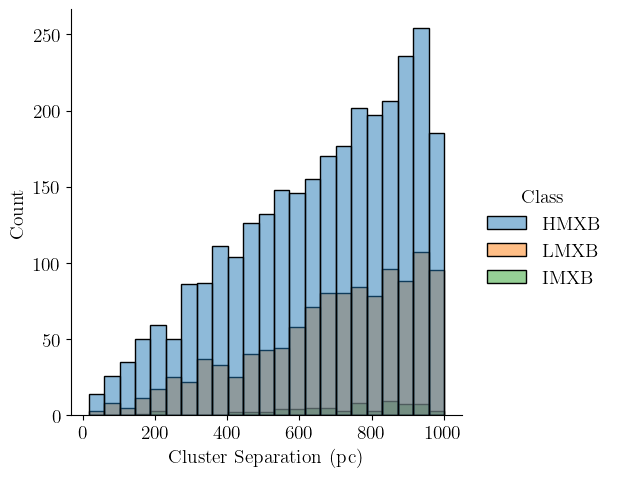

In [21]:
sns.displot(
    data=distances,
    x='Cluster Separation (pc)',
    kind='hist',
    hue='Class',
    legend=True
)
plt.show()

## Distance Plots

In [22]:
def make_plots(df, x, hue='Class', savefile=False, xlabel="Separation (pc)", bins=10):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

    sns.kdeplot(
        data=df,
        x=x,
        fill=True, 
        ax=ax[0], 
        alpha=0.5,
        hue=hue,
        palette='bright'
    )
    ax[0].set(xlabel=None)
    sns.histplot(
        data=df,
        bins=bins,
        x=x,
        hue=hue,
        legend=True,
        # kind='hist',
        palette='bright',
        alpha=0.5,
        ax=ax[1]
    )
    ax[1].set(xlabel=None)

    # ax[1].hist(x=velocity['Cluster Separation (pc)'].values, bins=30)
    # ax[1].set_ylabel('Counts')

    fig.supxlabel(xlabel, x=0.5, y=0.05)
    plt.tight_layout()
    if savefile:
        plt.savefig(M66_dir+'M66_XRB_ejection_compact_association_cat_separation.png')
    plt.show()

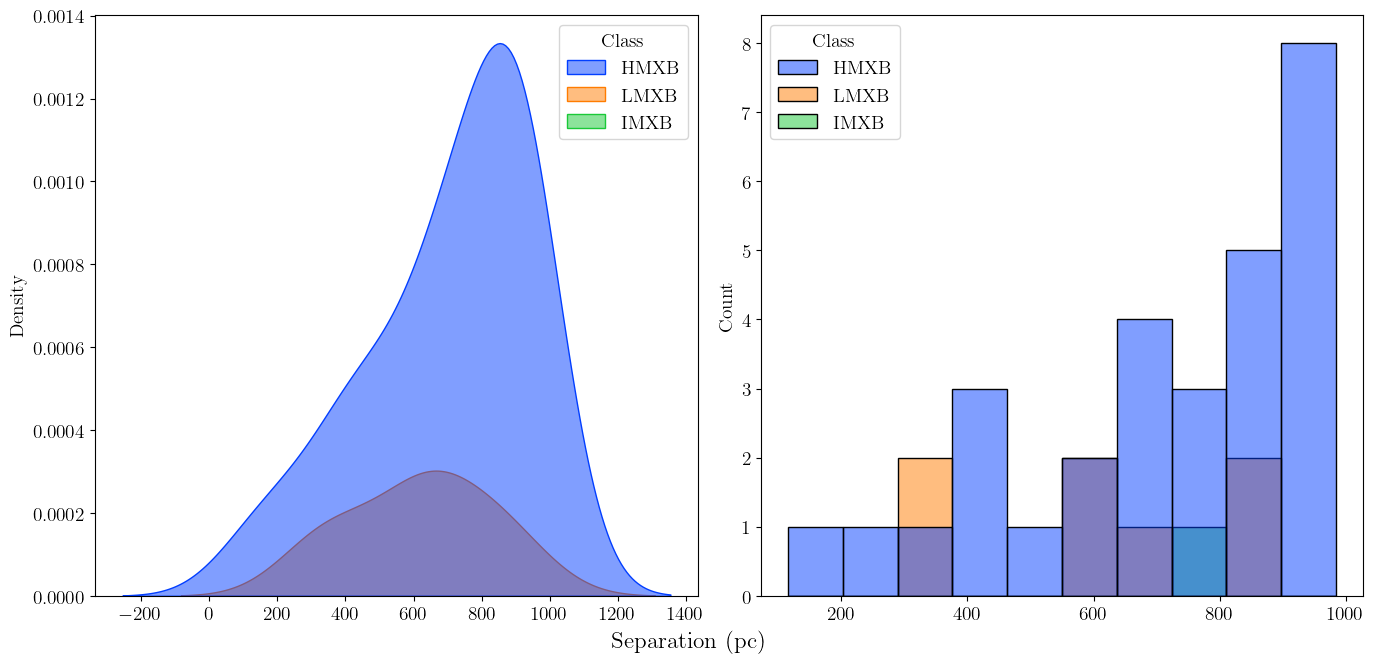

In [23]:
make_plots(df=xrb_cluster, x='Cluster Separation (pc)')

## Velocity Plots

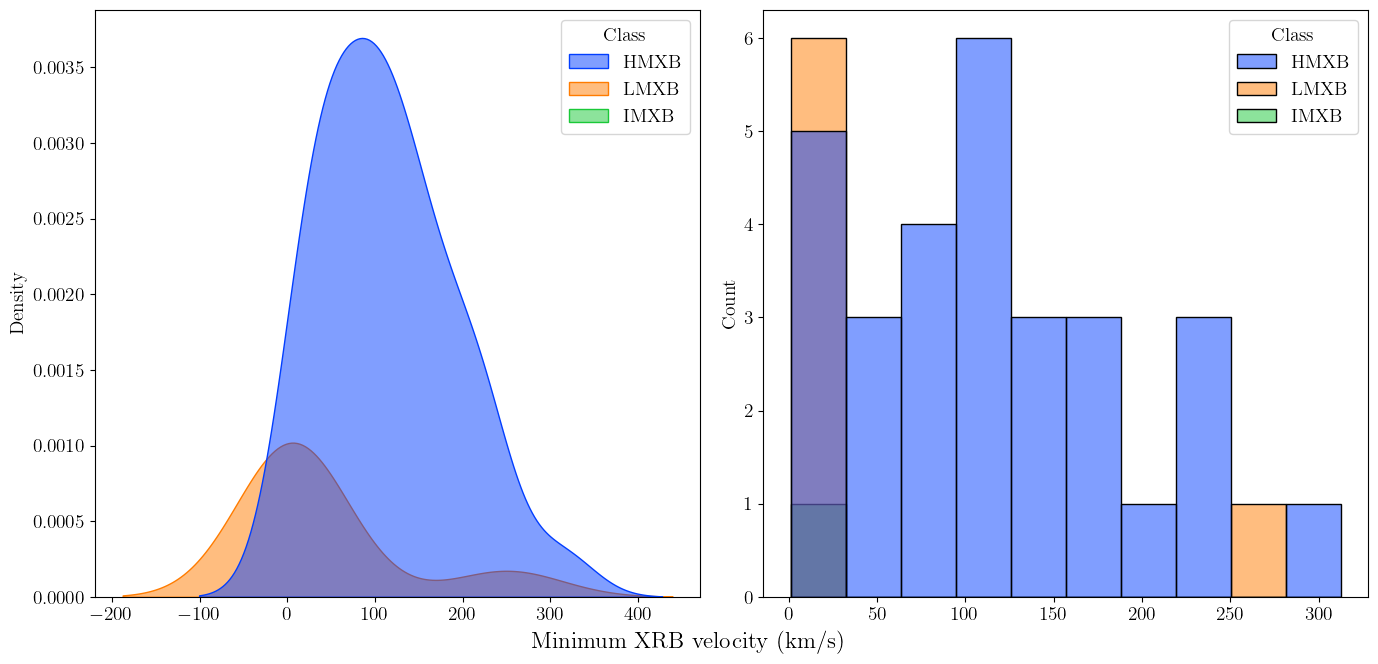

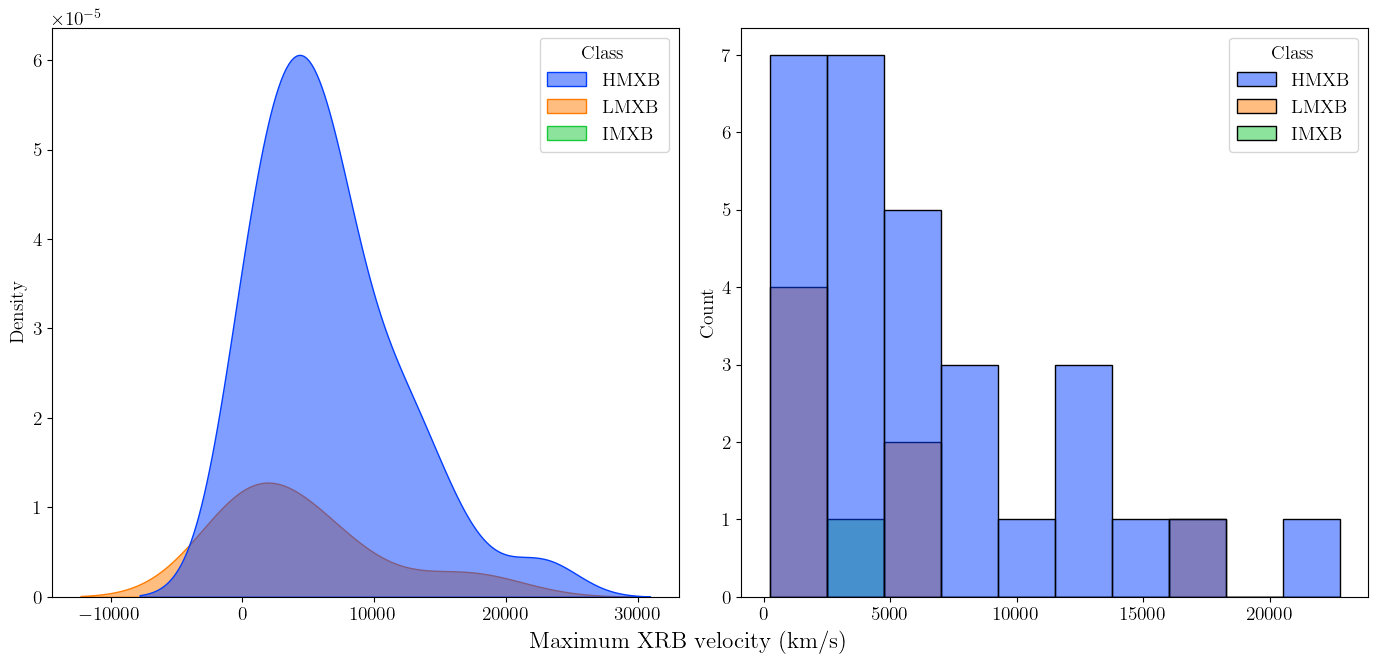

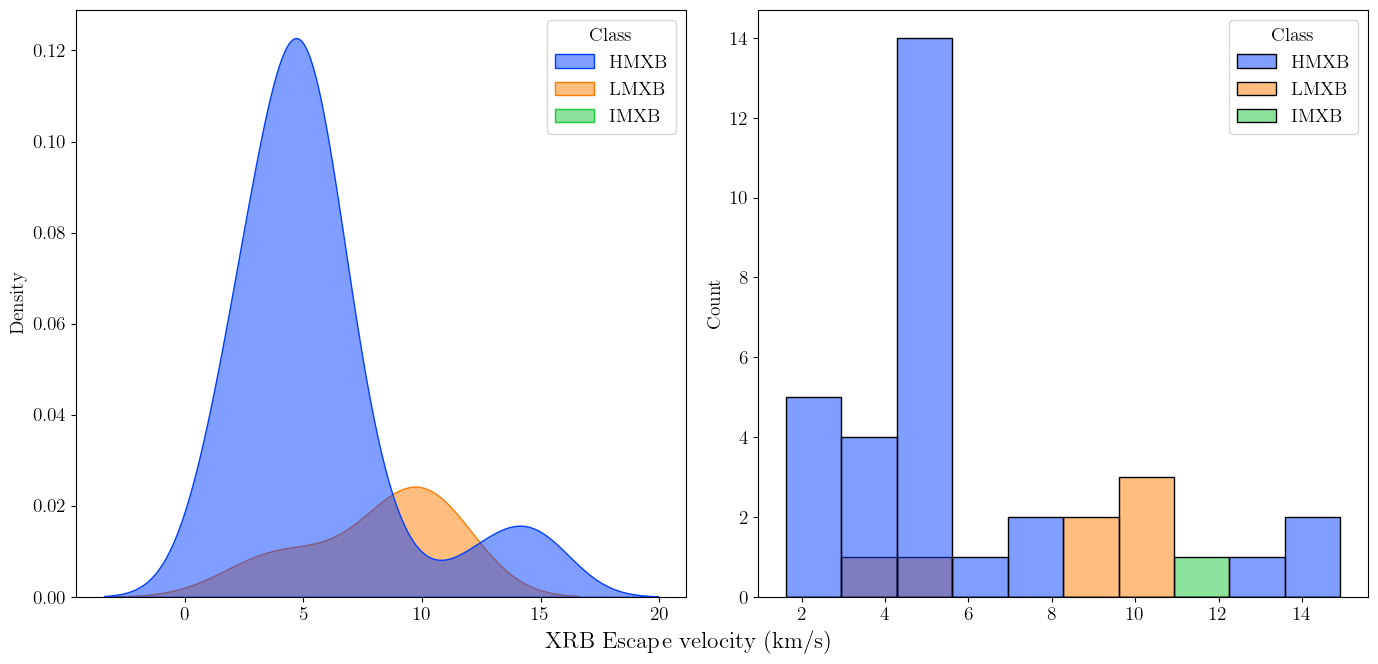

In [24]:
make_plots(
    df=velocity,
    x='Minimum XRB Velocity (km/s)',
    # bins=10,
    xlabel='Minimum XRB velocity (km/s)'
)
make_plots(
    df=velocity,
    x='Maximum XRB Velocity (km/s)',
    # bins=10,
    xlabel='Maximum XRB velocity (km/s)'
)
make_plots(
    df=velocity,
    x='Cluster Escape Velocity (km/s)',
    # bins=10,
    xlabel='XRB Escape velocity (km/s)'
)

## XRB Lx vs Distance

In [25]:
distances = distances.merge(M66_best[['CSC ID', 'LogLx']], on='CSC ID', how='left')

In [26]:
velocity = velocity.merge(M66_best[['CSC ID', 'LogLx']], on='CSC ID', how='left')

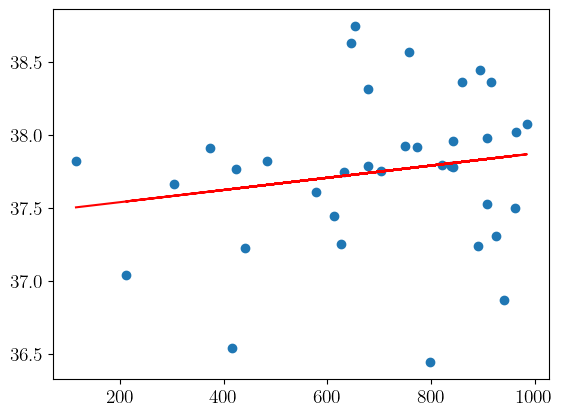

In [27]:
# Perform linear regression
from scipy import stats
x = np.delete(velocity['Cluster Separation (pc)'].values, 30)
y = np.delete(velocity['LogLx'].values, 30)
res = stats.linregress(np.nan_to_num(x), np.nan_to_num(y))
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

In [187]:
temp = velocity.drop(30)
temp.to_csv('/Users/undergradstudent/Downloads/temp.csv')

<Axes: xlabel='Cluster Separation (pc)', ylabel='LogLx'>

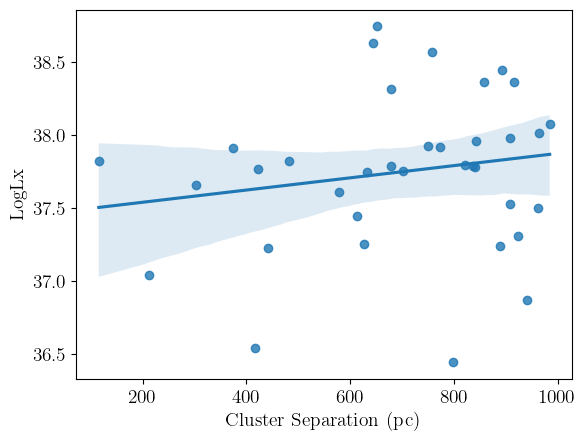

In [41]:
temp = velocity.drop(30)
sns.regplot(
    data=temp, 
    x="Cluster Separation (pc)", 
    y="LogLx",
    # hue='Class'
)

<Axes: xlabel='Cluster Separation (pc)', ylabel='LogLx'>

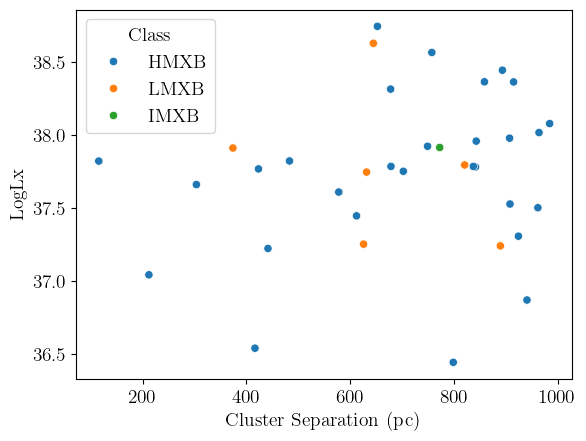

In [29]:
sns.scatterplot(
    data=velocity, 
    x="Cluster Separation (pc)", 
    y="LogLx",
    hue='Class'
)

# Perform linear regression after removing the -inf point in y
# from scipy import stats
# x = np.delete(velocity['Cluster Separation (pc)'].values, 30)
# y = np.delete(velocity['LogLx'].values, 30)
# res = stats.linregress(np.nan_to_num(x), np.nan_to_num(y))
# plt.scatter(x, y)
# plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')

## XRB Lx vs Velocity

<Axes: xlabel='Minimum XRB Velocity (km/s)', ylabel='LogLx'>

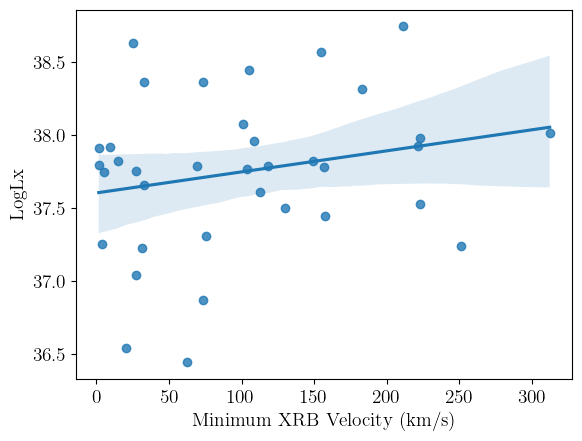

In [30]:
sns.regplot(
    data=temp, 
    x="Minimum XRB Velocity (km/s)", 
    y="LogLx",
)

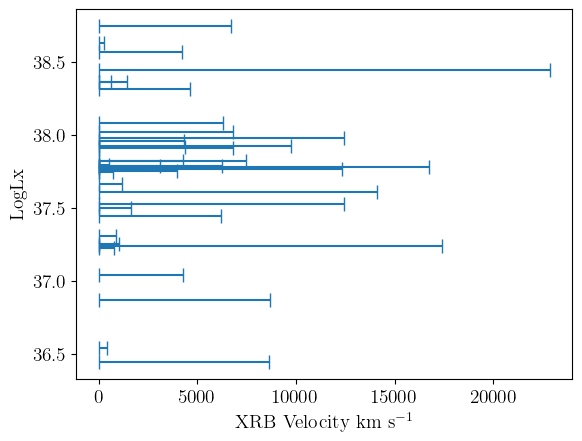

In [46]:
x = temp['Minimum XRB Velocity (km/s)'].values
y = temp['LogLx'].values
xerr = np.array([temp['Minimum XRB Velocity (km/s)'], temp['Maximum XRB Velocity (km/s)']])
fig, ax = plt.subplots()
ax.errorbar(x, y, fmt='none', xerr=xerr, capsize=5)
ax.set_xlabel(r'XRB Velocity km s$^{-1}$')
ax.set_ylabel('LogLx')
plt.show()

Text(0, 0.5, 'LogLx')

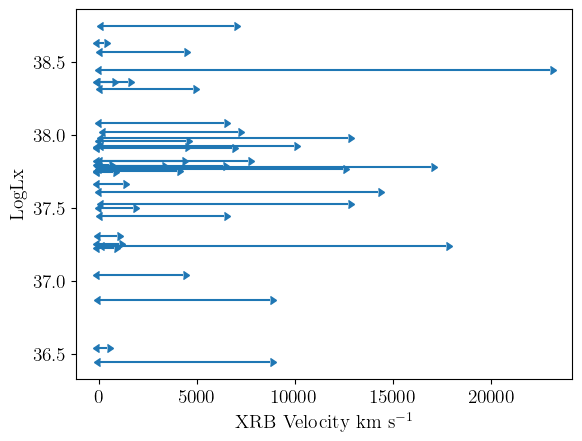

In [48]:
x = temp['Minimum XRB Velocity (km/s)']
y = temp['LogLx'].values
xerr = np.array([temp['Minimum XRB Velocity (km/s)'], temp['Maximum XRB Velocity (km/s)']])
# plt.errorbar(x, y, xerr=xerr, fmt='o', xlolims=True, xuplims=True)
plt.errorbar(x + x, y, xerr=xerr[0], fmt='none', xuplims=True)
plt.errorbar(x + x, y, xerr=xerr[1], fmt='none', xlolims=True)
plt.xlabel(r'XRB Velocity km s$^{-1}$')
plt.ylabel('LogLx')

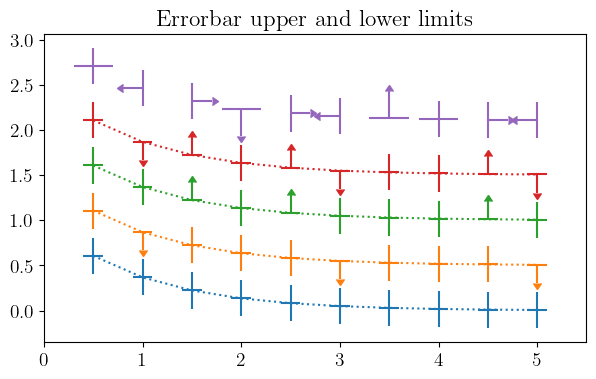

In [195]:
import matplotlib.pyplot as plt
import numpy as np

# example data
x = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
y = np.exp(-x)
xerr = 0.1
yerr = 0.2

# lower & upper limits of the error
lolims = np.array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0], dtype=bool)
uplims = np.array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=bool)
ls = 'dotted'

fig, ax = plt.subplots(figsize=(7, 4))

# standard error bars
ax.errorbar(x, y, xerr=xerr, yerr=yerr, linestyle=ls)

# including upper limits
ax.errorbar(x, y + 0.5, xerr=xerr, yerr=yerr, uplims=uplims,
            linestyle=ls)

# including lower limits
ax.errorbar(x, y + 1.0, xerr=xerr, yerr=yerr, lolims=lolims,
            linestyle=ls)

# including upper and lower limits
ax.errorbar(x, y + 1.5, xerr=xerr, yerr=yerr,
            lolims=lolims, uplims=uplims,
            marker='none', markersize=8,
            linestyle=ls)

# Plot a series with lower and upper limits in both x & y
# constant x-error with varying y-error
xerr = 0.2
yerr = np.full_like(x, 0.2)
yerr[[3, 6]] = 0.3

# mock up some limits by modifying previous data
xlolims = lolims
xuplims = uplims
lolims = np.zeros_like(x)
uplims = np.zeros_like(x)
lolims[[6]] = True  # only limited at this index
uplims[[3]] = True  # only limited at this index

# do the plotting
ax.errorbar(x, y + 2.1, xerr=xerr, yerr=yerr,
            xlolims=xlolims, xuplims=xuplims,
            uplims=uplims, lolims=lolims,
            marker='none', markersize=8,
            linestyle='none')

# tidy up the figure
ax.set_xlim((0, 5.5))
ax.set_title('Errorbar upper and lower limits')
plt.show()

## XRB Donor star age vs Cluster age

(-20.0, 450.0)

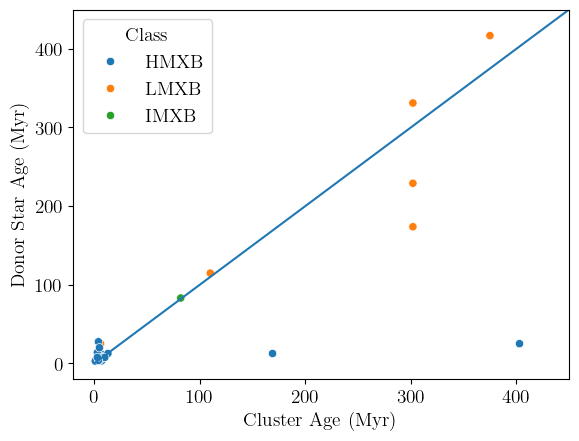

In [104]:
sns.scatterplot(
    data=velocity,
    x='Cluster Age (Myr)',
    y='Stellar Age (Myr)',
    hue='Class'
)

x = np.linspace(0, 500)
y = x
plt.plot(x, y)
plt.ylabel('Donor Star Age (Myr)')
plt.xlim(-20, 450)
plt.ylim(-20, 450)

Text(0, 0.5, 'Donor Star Age (Myr)')

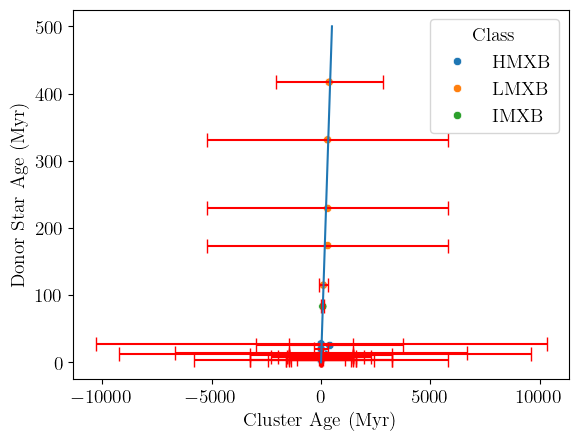

In [103]:
sns.scatterplot(
    data=velocity,
    x='Cluster Age (Myr)',
    y='Stellar Age (Myr)',
    hue='Class'
)
plt.errorbar(x=velocity['Cluster Age (Myr)'], 
            y=velocity['Stellar Age (Myr)'], 
            xerr=velocity['Cluster Age Err (Myr)'], 
            fmt='none', 
            ecolor='red', 
            capsize=5,
            zorder=1)
x = np.linspace(0, 500)
y = x
plt.plot(x, y)
plt.ylabel('Donor Star Age (Myr)')
# plt.xlim(-20, 450)
# plt.ylim(-20, 450)

## Stellar Age vs Cluster Age

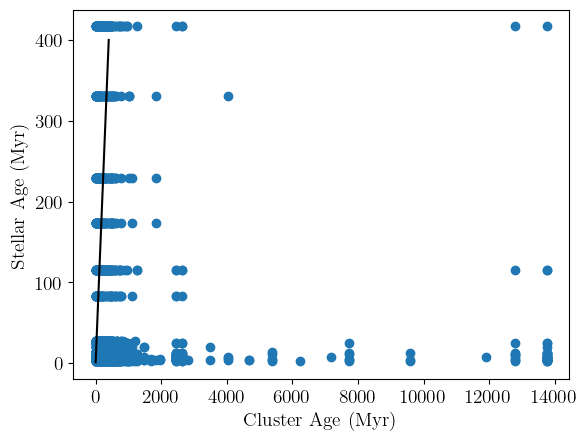

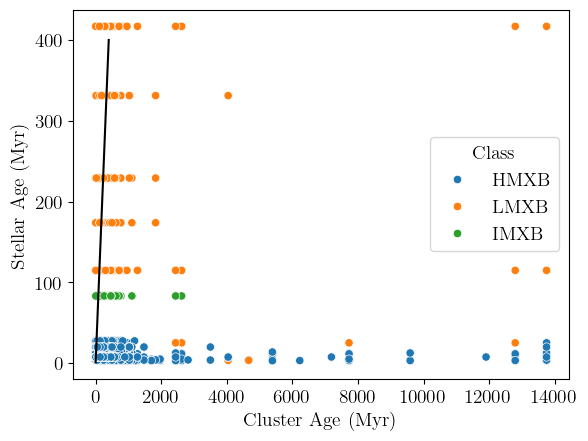

In [ ]:
x = temp['Cluster Age (Myr)'].values
xerr = temp['Cluster Age Err (Myr)']
y = temp['Stellar Age (Myr)'].values
plt.scatter(x, y, marker='o')
# plt.errorbar(x, y, xerr=xerr, fmt='o', markersize=2, alpha=0.5)
plt.ylabel("Stellar Age (Myr)")
plt.xlabel('Cluster Age (Myr)')
x = np.linspace(1, 400)
y = x
plt.plot(x, y, c='k')

plt.show()

sns.scatterplot(
    data=temp, 
    x='Cluster Age (Myr)',
    y='Stellar Age (Myr)',
    hue='Class'
)
x = np.linspace(1, 400)
y = x
plt.plot(x, y, c='k')
sns.move_legend(ax, "upper right")

## M/R vs Velocity

In [321]:
y_err

array([580078.96848378, 580078.96848378, 580078.96848378, 580078.96848378,
       580078.96848378, 580078.96848378, 580078.96848378,  41310.92808682,
        10343.5805877 ,  59195.97324828,  38835.75033697, 580078.96848378,
        76886.93527942,  45039.1403641 ,  38835.75033697,  76886.93527942,
        76886.93527942,  47267.9418992 ,   2230.19348488, 171834.26371776,
        57750.96170711,  73143.93840804,   7889.07564996,  49602.06078989,
       301409.58937889, 325157.8907386 ,  12246.95856122, 148890.64087388,
       148890.64087388, 157872.62216593, 148890.64087388,   1592.95572636,
       113063.16697993,  31102.83766   ,  75618.3103399 ,   8318.99202697,
        17816.32151076])

<ErrorbarContainer object of 3 artists>

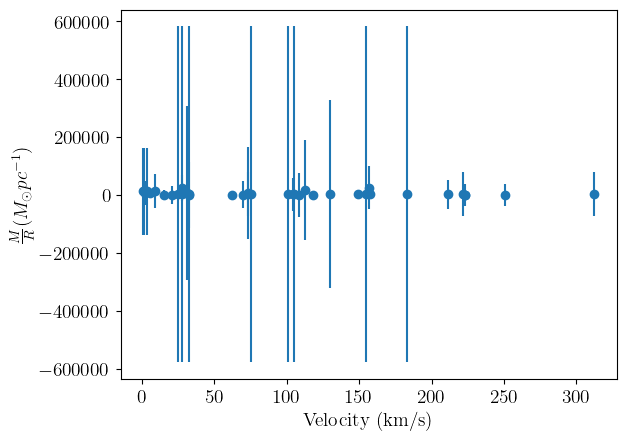

In [ ]:
mass = velocity['Cluster Mass (M_sun)'].values
radius = velocity['Cluster half-mass Radius (pc)'].values 

# y measurements
ratio = mass / radius
y_err = velocity['Cluster Mass Err (M_sun)'].values

# x measurements
vel = velocity['Minimum XRB Velocity (km/s)'].values
xerr = 

plt.xlabel('Velocity (km/s)')
plt.ylabel(r'$\frac{M}{R}(M_{\odot} pc^{-1})$')
plt.errorbar(vel, ratio, fmt='o', 
             yerr=y_err,
             xerr
)

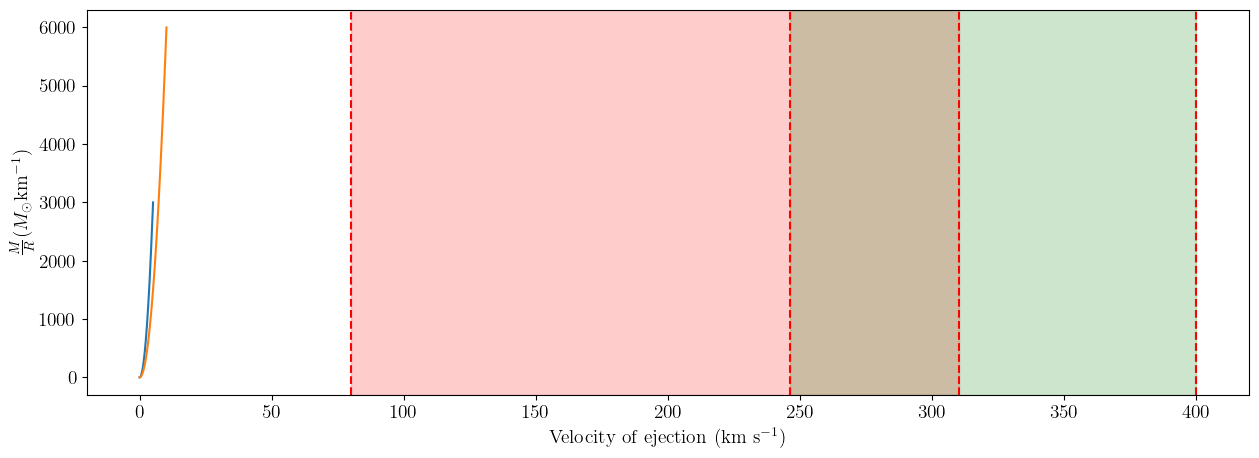

In [301]:
from astropy.constants import G

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel('Velocity of ejection (km s$^{-1}$)')
ax.set_ylabel(r'$\frac{M}{R} (M_{\odot}$km$^{-1})$')

G = 4.302e-3 # pc Msun^(-1) (km/s)^2
y = np.arange(0, 3000, 1)
x = np.sqrt(2 * G * y)
plt.plot(x, y)
plt.plot(2 * x, 2 * y)

# BHXB ejection velocities
plt.axvline(x=80, color='r', linestyle='--')
plt.axvline(x=310, color='r', linestyle='--')
ax.axvspan(80, 310, color='red', alpha=0.2)

# NSXB ejection velocities
plt.axvline(x=246, color='r', linestyle='--')
plt.axvline(x=400, color='r', linestyle='--')
ax.axvspan(246, 400, color='green', alpha=0.2)

# ax.set_ylim((0e6, 0.75e6))
plt.show()


In [314]:
clustercat

,Cluster ID,Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc)
0,14,1.440696,1.0,1.0,8719.629994,2694.287932,0.31,0.04,0.155719,0.48,0.7104,0.028416,1.556879
1,46,1.652545,2440.0,1412.0,435789.158150,132243.181503,0.15,0.17,0.675790,1.32,1.9536,0.078144,4.281416
2,55,1.554934,182.0,28.0,17467.385090,2360.828542,0.00,0.01,0.798219,0.96,1.4208,0.056832,3.113757
3,68,1.723422,210.0,0.0,80145.110419,9281.609214,0.01,0.03,0.181574,1.55,2.2940,0.091760,5.027420
4,90,1.869660,500.0,151.0,55569.664342,1130.107884,0.00,0.10,0.702583,2.50,3.7000,0.148000,8.108742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,10668,1.837798,1028.0,625.0,15243.314080,6490.579020,0.04,0.37,0.141133,1.32,1.9536,0.078144,4.281416
2708,10670,1.626464,5.0,2.0,8629.588626,2126.057035,0.92,0.13,0.060492,1.18,1.7464,0.069856,3.827326
2709,10671,1.739450,118.0,347.0,11339.952560,1688.263020,0.35,0.24,0.026141,1.55,2.2940,0.091760,5.027420
2710,10672,1.906561,667.0,557.0,15856.958755,2760.559736,0.08,0.33,0.046162,3.09,4.5732,0.182928,10.022406
